In [ ]:
!pip install tensorflow
!pip install keras

# I - Préliminaires - Fonctions utiles

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matrice de confusion',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Vérité Terrain')
    plt.xlabel('Prédiction')

# II - Entraînement d'un CNN pour la classification sur CIFAR10

### II.1. Chargement et Dimensionnement de la base CIFAR10

In [ ]:
from keras import backend as K
print(K.backend())

tensorflow


In [ ]:
from keras.datasets import cifar10

Réduction de la taille du dataset (pour accélérer l'apprentissage), et standardisation des données

In [ ]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()
print("Dimension de la base d'apprentissage CIFAR10 :",x_train_full.shape)
print("Dimension des vecteurs d'étiquette de classe :",y_train_full.shape)
print("Dimension de la base de test CIFAR10 :",x_test_full.shape)

170498071/170498071 [==============================] - 3s 0us/step
Dimension de la base d'apprentissage CIFAR10 : (50000, 32, 32, 3)
Dimension des vecteurs d'étiquette de classe : (50000, 1)
Dimension de la base de test CIFAR10 : (10000, 32, 32, 3)


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
n_training_samples = 5000
n_other_samples = 2000

def standardize(img_data):
    img_data_mean = np.mean(img_data, axis=(1,2), keepdims=True)
    img_data_std = np.std(img_data, axis=(1,2), keepdims=True)
    img_data = (img_data - img_data_mean) / img_data_std
    return img_data

train_ids = np.random.choice(len(x_train_full), size=n_training_samples, replace=False)
other_ids = np.random.choice(len(x_test_full), size=n_other_samples, replace=False)

n_valid = n_other_samples // 2
val_ids = other_ids[:n_valid]
test_ids = other_ids[n_valid:]

x_train_initial, y_train = x_train_full[train_ids], y_train_full[train_ids]
x_val_initial, y_val = x_test_full[val_ids], y_test_full[val_ids]
x_test_initial, y_test = x_test_full[test_ids], y_test_full[test_ids]

x_train = standardize(x_train_initial)
x_val = standardize(x_val_initial)
x_test = standardize(x_test_initial)

print("Dimension de notre base d'apprentissage :",x_train.shape)
print("Dimension des vecteurs d'étiquette de classe :",y_train.shape)
print("Dimension de notre base de validation :",x_val.shape)
print("Dimension de notre base de test :",x_test.shape)


Dimension de notre base d'apprentissage : (5000, 32, 32, 3)
Dimension des vecteurs d'étiquette de classe : (5000, 1)
Dimension de notre base de validation : (1000, 32, 32, 3)
Dimension de notre base de test : (1000, 32, 32, 3)


On affiche quelques images d'entraînement avec leur étiquette...

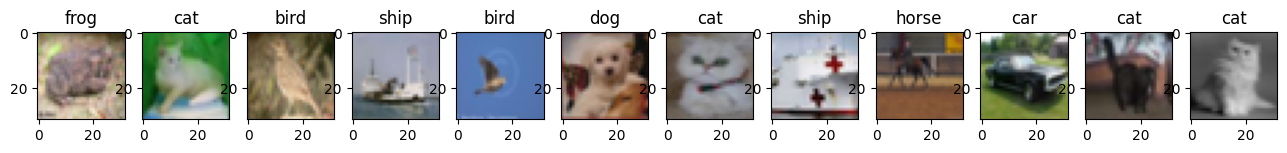

In [ ]:
n_display = 12
random_ids = np.random.choice(len(x_train), n_display, replace=False)
f, axarr = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    axarr[k].imshow(x_train_initial[random_ids[k]])
    axarr[k].title.set_text(classes[y_train[random_ids[k]][0]])

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print("Dimension des matrices d'étiquette de classe (train) :",y_train.shape)
print("Dimension des matrices d'étiquette de classe (val) :",y_val.shape)
print("Dimension des matrices d'étiquette de classe (test) :",y_test.shape)

Dimension des matrices d'étiquette de classe (train) : (5000, 10)
Dimension des matrices d'étiquette de classe (val) : (1000, 10)
Dimension des matrices d'étiquette de classe (test) : (1000, 10)


### II.2. Definition de l'architecture du CNN

Un simple réseau convolutionnel...

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l2

model = Sequential()
model.add(Conv2D(filters=8,
                kernel_size = (3, 3),
                activation = 'relu',
                padding = 'same',
                input_shape = (32, 32, 3),
                kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))
model.add(Dense(10, activation='softmax', kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))

On enregistre les poids initiaux pour plus tard...

In [ ]:
weights_init = model.get_weights()

### II.3. Definition de la fonction de coût et choix de l'algorithme d'optimisation

In [ ]:
from keras.optimizers import Adam, SGD

# opt = SGD(lr=0.01,momentum=0.0)
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

On affiche un résumé de la structure du modèle...

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 32)         

### II.4. Entraînement du CNN

*Definition du callback. A passer en première lecture.*

In [ ]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()
filepath = "my_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=2)

callbacks = [time_callback, checkpoint]

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 7s 33ms/step - loss: 2.0477 - acc: 0.2652 - val_loss: 1.9091 - val_acc: 0.3030
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 1.7170 - acc: 0.3873
Epoch 2: val_acc improved from -inf to 0.42300, saving model to my_model.h5
157/157 [==============================] - 4s 24ms/step - loss: 1.7151 - acc: 0.3884 - val_loss: 1.6433 - val_acc: 0.4230
Epoch 3/20
157/157 [==============================] - 4s 23ms/step - loss: 1.5636 - acc: 0.4502 - val_loss: 1.5866 - val_acc: 0.4310
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 1.4200 - acc: 0.5052
Epoch 4: val_acc improved from 0.42300 to 0.44900, saving model to my_model.h5
157/157 [==============================] - 5s 31ms/step - loss: 1.4201 - acc: 0.5052 - val_loss: 1.5714 - val_acc: 0.4490
Epoch 5/20
157/157 [==============================] - 4s 24ms/step - loss: 1.3065 - acc: 0.5438 - val_loss: 1.4857 - val_acc: 0.4670
Epoch 6/20
157/157 [

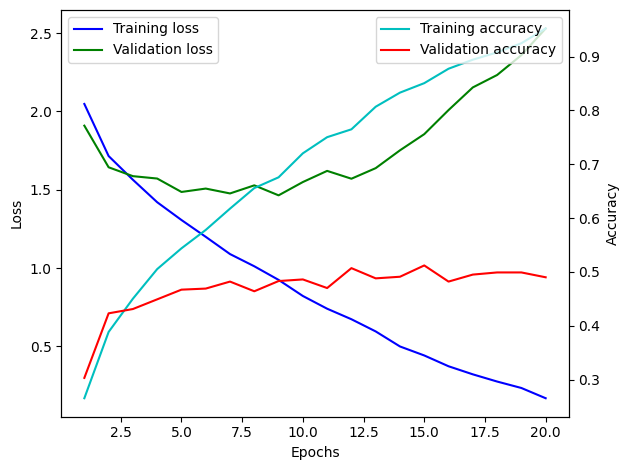

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epochs, loss_values, color='b', label='Training loss')
ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
ax1.tick_params(axis='y')
plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(loc=1)
plt.show()

Statistiques sur le temps d'entraînement d'une epoch

In [ ]:
times = time_callback.times
print("Mean: {}".format(np.mean(times)))
print("Std: {}".format(np.std(times)))

Tracé des courbes d'évolution des fonctions de coût

In [ ]:
history.history.keys()

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epochs, loss_values, color='b', label='Training loss')
ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
ax1.tick_params(axis='y')
plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(loc=1)
plt.show()

### II.5. Entraînement d'un CNN avec points d'arrêt et reprises (à passer en première lecture)

Pour des entraînements plus conséquents, il est primordial d'enregistrer les modèles intermédiaires afin de ne pas tout perdre si l'apprentissage venait à s'interrompre de façon impromptue. On peut enregistrer le modèle dans un fichier .hdf

Si vous regardez plus attentivement, lors de l'entrainement précédent nous avons crée un object **ModelCheckpoint**. Il permet d'enregistrer le meilleur modèle (au sens d'une metrique à préciser) dans un fichier nommé *my_model.h5*. Verifiez que ce fichier se trouve bien votre espace de travail.

L'argument ***period*** de l'objet ModelCheckpoint vous permet de definir la fréquence des enregistrements.

In [ ]:
from keras.models import load_model

Une fois le modele obtenu, on peut l'enregister et le recharger comme ceci: load_model(filepath)

In [ ]:
from keras.models import load_model

import pathlib
file = pathlib.Path(filepath)
if file.exists():
    model = load_model(filepath)
else:
    model.set_weights(weights_init)
    callbacks = [time_callback,checkpoint]
history_2 = model.fit(x_train, y_train, batch_size=8, epochs=10, verbose=1, validation_data=(x_val, y_val), callbacks = callbacks)

# III - Test et Évaluation du modèle en prédiction

### III.1. Test du modèle sur les données de test

Testons la prédiction de notre modèle sur quelques images de test au hasard...

1/1 [==============================] - 0s 24ms/step


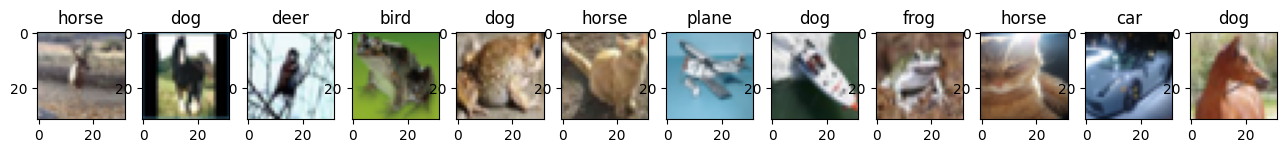

In [ ]:
random_ids = np.random.choice(len(x_test), n_display, replace=False)
pred = np.argmax(model.predict(x_test[random_ids]), axis=1)
f, axarr = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    axarr[k].imshow(x_test_initial[random_ids[k]])
    axarr[k].title.set_text(classes[pred[k]])

Vos premiers résultats semblent-ils corrects ?

Hum ! Affichons à présent la précision sur l'ensemble de votre base :

In [ ]:
print("Précision du réseau sur les {} images d'entraînement : {:.2f} %".format(n_training_samples, 100 * history_dict['acc'][-1]))
print("Précision du réseau sur les {} images de validation : {:.2f} %".format(n_valid, 100 * history_dict['val_acc'][-1]))

Précision du réseau sur les 5000 images d'entraînement : 95.24 %
Précision du réseau sur les 1000 images de validation : 49.00 %


In [ ]:
def accuracy_per_class(model):
    n_classes = len(classes)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    pred = np.argmax(model.predict(x_test), axis=1)
    for i in range(len(y_test)):
        confusion_matrix[np.argmax(y_test[i]), pred[i]] += 1

    print("{:<10} {:^10}".format("Classe", "Précision (%)"))
    total_correct = 0
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        total_correct += class_correct
        percentage_correct = 100.0 * float(class_correct) / class_total
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    test_acc = 100.0 * float(total_correct) / len(y_test)
    print("Précision du réseau sur les {} images de test : {:.2f} %".format(len(y_test),test_acc))
    return confusion_matrix

confusion_matrix = accuracy_per_class(model)

32/32 [==============================] - 0s 9ms/step
Classe     Précision (%)
plane        50.52   
car          56.48   
bird         22.89   
cat          29.59   
deer         33.66   
dog          50.94   
frog         41.18   
horse        64.08   
ship         55.21   
truck        50.94   
Précision du réseau sur les 1000 images de test : 46.10 %


### III.2. Matrices de Confusion

Les matrices de confusion nous renseignent plus précisément sur la nature des erreurs commises par notre modèle.

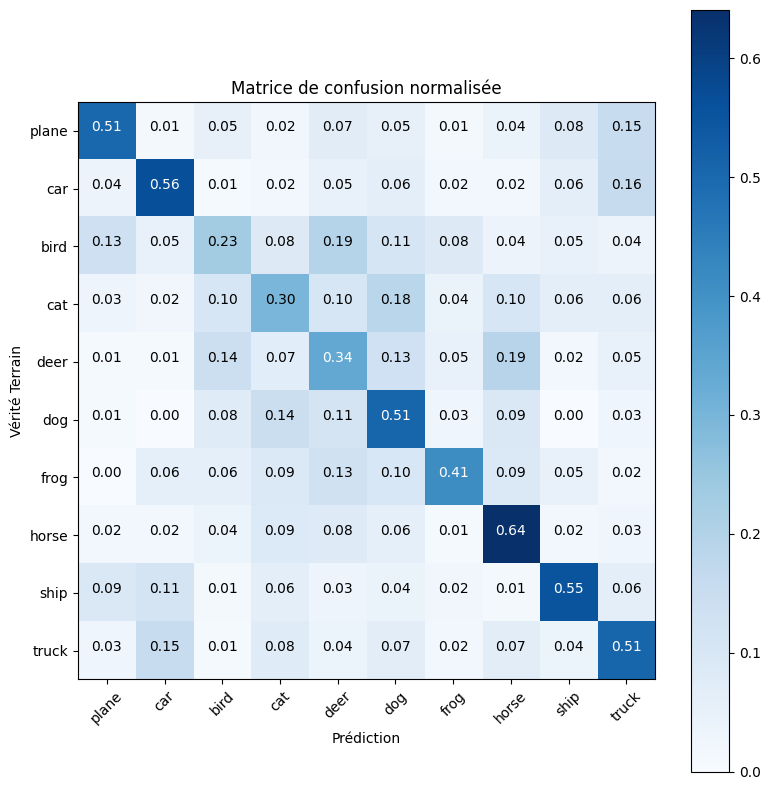

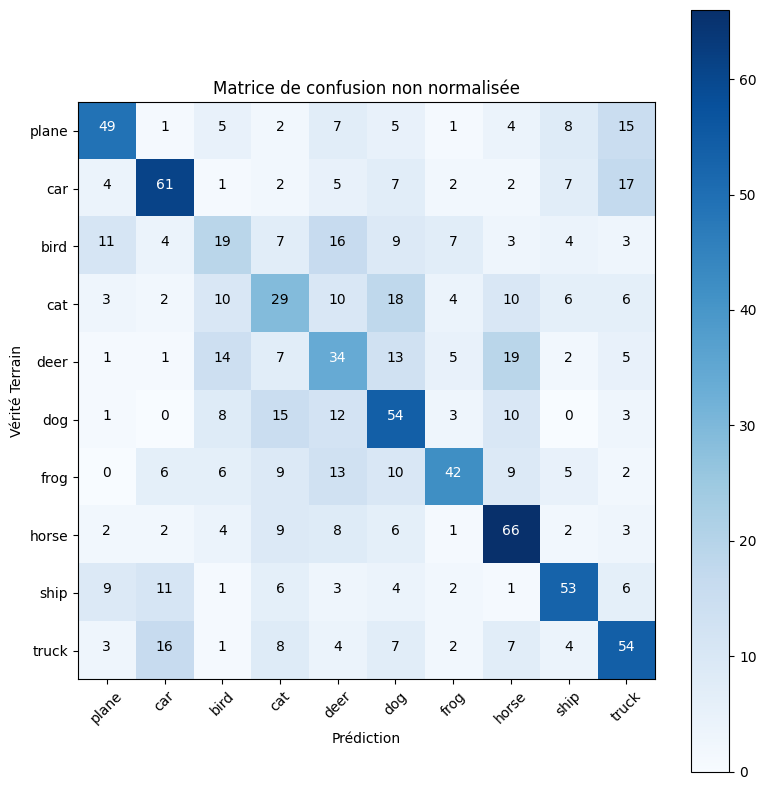

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Matrice de confusion normalisée')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Matrice de confusion non normalisée')

# IV - Visualisation des zones d'activation

In [ ]:
from keras.models import Model

reduced_model = Model(inputs=model.inputs, outputs=model.layers[5].output)
reduced_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3_input (InputLayer  [(None, 32, 32, 3)]       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                            
                                                          

In [ ]:
feature_maps = reduced_model.predict(x_test)

32/32 [==============================] - 0s 8ms/step


In [ ]:
def get_mask(k):
    feature_maps_positive = np.maximum(feature_maps[k], 0)
    mask = np.sum(feature_maps_positive,axis=2)
    mask = mask / np.max(mask)
    return mask

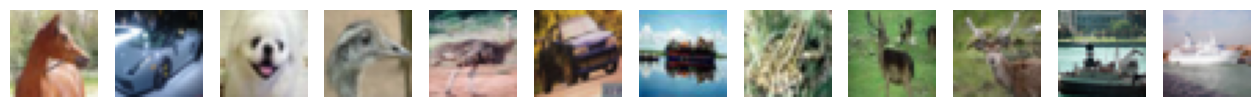

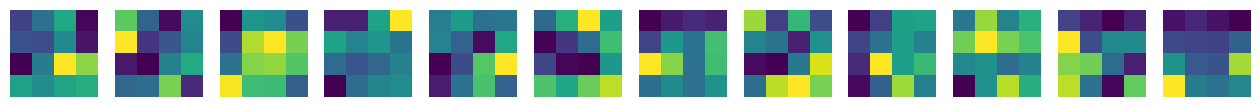

In [ ]:
random_ids = np.random.choice(len(x_test), n_display, replace=False)
f, rd_img = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    img = x_test_initial[random_ids[k]]
    rd_img[k].imshow(img)
    rd_img[k].axis('off')
f, rd_maps = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    mask = get_mask(random_ids[k])
    rd_maps[k].imshow(mask)
    rd_maps[k].axis('off')

In [ ]:
from keras.models import Model

reduced_model = Model(inputs=model.inputs, outputs=model.layers[3].output)
reduced_model.summary()

feature_maps = reduced_model.predict(x_test)

def get_mask(k):
    feature_maps_positive = np.maximum(feature_maps[k], 0)
    mask = np.sum(feature_maps_positive,axis=2)
    mask = mask / np.max(mask)
    return mask

random_ids = np.random.choice(len(x_test), n_display, replace=False)
f, rd_img = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    img = x_test_initial[random_ids[k]]
    rd_img[k].imshow(img)
    rd_img[k].axis('off')
f, rd_maps = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    mask = get_mask(random_ids[k])
    rd_maps[k].imshow(mask)
    rd_maps[k].axis('off')

In [ ]:
from keras.models import Model

reduced_model = Model(inputs=model.inputs, outputs=model.layers[5].output)
reduced_model.summary()

feature_maps = reduced_model.predict(x_test)

def get_mask(k):
    feature_maps_positive = np.maximum(feature_maps[k], 0)
    mask = np.sum(feature_maps_positive,axis=2)
    mask = mask / np.max(mask)
    return mask

random_ids = np.random.choice(len(x_test), n_display, replace=False)
f, rd_img = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    img = x_test_initial[random_ids[k]]
    rd_img[k].imshow(img)
    rd_img[k].axis('off')
f, rd_maps = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    mask = get_mask(random_ids[k])
    rd_maps[k].imshow(mask)
    rd_maps[k].axis('off')

# task code

### Apprentissage Q2 - influence de BATCH_SIZE

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l2

for BATCH_SIZE in [1,2,4,8,16,32,64,128,256]:
  model = Sequential()
  model.add(Conv2D(filters=8,
                  kernel_size = (3, 3),
                  activation = 'relu',
                  padding = 'same',
                  input_shape = (32, 32, 3),
                  kernel_regularizer = l2(0.00)))
  model.add(Dropout(0.0))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(64, activation='relu', kernel_regularizer = l2(0.00)))
  model.add(Dropout(0.0))
  model.add(Dense(10, activation='softmax', kernel_regularizer = l2(0.00)))
  model.add(Dropout(0.0))

  weights_init = model.get_weights()

  opt = SGD(lr=0.01,momentum=0.0)
  # opt = Adam(lr=0.001)
  model.compile(optimizer=opt,
               loss='categorical_crossentropy',
               metrics=['acc'])

  class TimeHistory(Callback):
      def on_train_begin(self, logs={}):
          self.times = []

      def on_epoch_begin(self, batch, logs={}):
          self.epoch_time_start = time.time()

      def on_epoch_end(self, batch, logs={}):
          self.times.append(time.time() - self.epoch_time_start)
  time_callback = TimeHistory()
  filepath = "my_model.h5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=2)

  callbacks = [time_callback, checkpoint]

  history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, validation_data=(x_val, y_val), callbacks=callbacks)

  times = time_callback.times
  print("Mean: {}".format(np.mean(times)))
  print("Std: {}".format(np.std(times)))

  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc_values = history_dict['acc']
  val_acc_values = history_dict['val_acc']

  epochs = range(1, len(history_dict['acc']) + 1)

  fig, ax1 = plt.subplots()
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.plot(epochs, loss_values, color='b', label='Training loss')
  ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
  ax1.tick_params(axis='y')
  plt.legend()

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
  ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
  ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
  ax2.tick_params(axis='y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.legend(loc=1)
  plt.show()

### Apprentissage Q3 - influence de optimateur

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l2
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import time
import matplotlib.pyplot as plt

for optr in [1,2,3]:
  model = Sequential()
  model.add(Conv2D(filters=8,
                  kernel_size = (3, 3),
                  activation = 'relu',
                  padding = 'same',
                  input_shape = (32, 32, 3),
                  kernel_regularizer = l2(0.00)))
  model.add(Dropout(0.0))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(64, activation='relu', kernel_regularizer = l2(0.00)))
  model.add(Dropout(0.0))
  model.add(Dense(10, activation='softmax', kernel_regularizer = l2(0.00)))
  model.add(Dropout(0.0))

  weights_init = model.get_weights()

  if optr == 1:
    opt = SGD(lr=0.01)
  if optr == 2:
    opt = SGD(lr=0.01, momentum=0.1)
  if optr == 3:
    opt = Adam(lr=0.01)

  model.compile(optimizer=opt,
               loss='categorical_crossentropy',
               metrics=['acc'])

  class TimeHistory(Callback):
      def on_train_begin(self, logs={}):
          self.times = []

      def on_epoch_begin(self, batch, logs={}):
          self.epoch_time_start = time.time()

      def on_epoch_end(self, batch, logs={}):
          self.times.append(time.time() - self.epoch_time_start)

  time_callback = TimeHistory()
  filepath = "my_model.h5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=2)

  callbacks = [time_callback, checkpoint]

  history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val), callbacks=callbacks)

  times = time_callback.times
  print("Mean: {}".format(np.mean(times)))
  print("Std: {}".format(np.std(times)))

  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc_values = history_dict['acc']
  val_acc_values = history_dict['val_acc']

  epochs = range(1, len(history_dict['acc']) + 1)

  fig, ax1 = plt.subplots()
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.plot(epochs, loss_values, color='b', label='Training loss')
  ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
  ax1.tick_params(axis='y')
  plt.legend()

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
  ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
  ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
  ax2.tick_params(axis='y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.legend(loc=1)
  plt.show()

### Approfondissement du modèle - Q1 nombre des couches

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l2

model = Sequential()
model.add(Conv2D(filters=8,
                 kernel_size=(3, 3),
                 activation='relu',
                 padding='same',
                 input_shape=(32, 32, 3),
                 kernel_regularizer=l2(0.00)))
model.add(MaxPool2D(pool_size=(2, 2)))

# # 新增的第一个卷积层
model.add(Conv2D(filters=16,  # 增加滤波器的数量
                 kernel_size=(3, 3),
                 activation='relu',
                 padding='same',
                 kernel_regularizer=l2(0.00)))
model.add(MaxPool2D(pool_size=(2, 2)))

# 新增的第二个卷积层
model.add(Conv2D(filters=32,  # 再次增加滤波器的数量
                 kernel_size=(3, 3),
                 activation='relu',
                 padding='same',
                 kernel_regularizer=l2(0.00)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0)))
model.add(Dropout(0.0))
model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.0)))

### Approfondissement du modèle - Q2 best model

Epoch 1/20
157/157 [==============================] - 4s 21ms/step - loss: 2.2350 - acc: 0.1576 - val_loss: 2.1301 - val_acc: 0.2170
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 2.0769 - acc: 0.2430
Epoch 2: val_acc improved from -inf to 0.19900, saving model to my_model.h5
157/157 [==============================] - 3s 19ms/step - loss: 2.0769 - acc: 0.2428 - val_loss: 2.1322 - val_acc: 0.1990
Epoch 3/20
  7/157 [>.............................] - ETA: 2s - loss: 2.0026 - acc: 0.2455

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 3s 19ms/step - loss: 1.9758 - acc: 0.2888 - val_loss: 1.9600 - val_acc: 0.3120
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 1.9017 - acc: 0.3181
Epoch 4: val_acc improved from 0.19900 to 0.25100, saving model to my_model.h5
157/157 [==============================] - 4s 27ms/step - loss: 1.9016 - acc: 0.3182 - val_loss: 2.0668 - val_acc: 0.2510
Epoch 5/20
157/157 [==============================] - 3s 19ms/step - loss: 1.8303 - acc: 0.3520 - val_loss: 1.8159 - val_acc: 0.3490
Epoch 6/20
155/157 [============================>.] - ETA: 0s - loss: 1.7670 - acc: 0.3760
Epoch 6: val_acc improved from 0.25100 to 0.33200, saving model to my_model.h5
157/157 [==============================] - 3s 19ms/step - loss: 1.7675 - acc: 0.3756 - val_loss: 1.8213 - val_acc: 0.3320
Epoch 7/20
157/157 [==============================] - 3s 21ms/step - loss: 1.7124 - acc: 0.3870 - val_loss: 1.7810 - val_acc: 0.3520
Epoch 8/20
156/157 [========

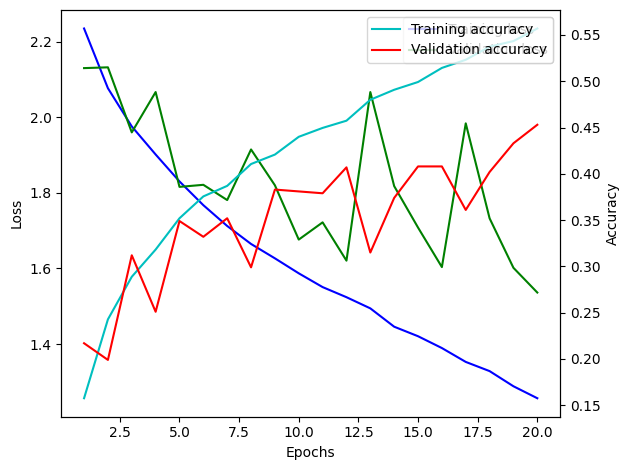

Epoch 1/20
157/157 [==============================] - 5s 28ms/step - loss: 2.2614 - acc: 0.1436 - val_loss: 2.1712 - val_acc: 0.2150
Epoch 2/20
154/157 [============================>.] - ETA: 0s - loss: 2.0997 - acc: 0.2285
Epoch 2: val_acc improved from -inf to 0.26500, saving model to my_model.h5
157/157 [==============================] - 3s 19ms/step - loss: 2.0987 - acc: 0.2282 - val_loss: 2.0173 - val_acc: 0.2650
Epoch 3/20
157/157 [==============================] - 4s 23ms/step - loss: 1.9886 - acc: 0.2772 - val_loss: 2.0635 - val_acc: 0.2170
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 1.8979 - acc: 0.3240
Epoch 4: val_acc improved from 0.26500 to 0.32500, saving model to my_model.h5
157/157 [==============================] - 4s 26ms/step - loss: 1.8986 - acc: 0.3238 - val_loss: 1.9050 - val_acc: 0.3250
Epoch 5/20
157/157 [==============================] - 3s 19ms/step - loss: 1.8194 - acc: 0.3600 - val_loss: 1.9096 - val_acc: 0.2850
Epoch 6/20
154/157 [

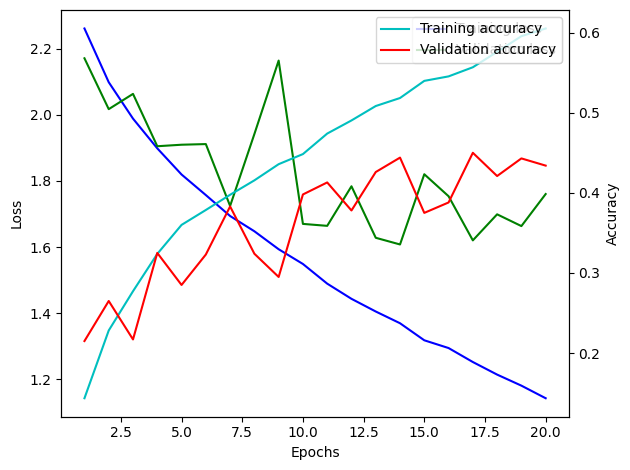

Epoch 1/20
157/157 [==============================] - 4s 21ms/step - loss: 2.2644 - acc: 0.1718 - val_loss: 2.1633 - val_acc: 0.2450
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 2.1035 - acc: 0.2476
Epoch 2: val_acc improved from -inf to 0.27500, saving model to my_model.h5
157/157 [==============================] - 4s 27ms/step - loss: 2.1025 - acc: 0.2474 - val_loss: 2.0068 - val_acc: 0.2750
Epoch 3/20
157/157 [==============================] - 3s 20ms/step - loss: 1.9924 - acc: 0.2878 - val_loss: 1.9861 - val_acc: 0.2860
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 1.9080 - acc: 0.3155
Epoch 4: val_acc improved from 0.27500 to 0.33000, saving model to my_model.h5
157/157 [==============================] - 3s 20ms/step - loss: 1.9083 - acc: 0.3156 - val_loss: 1.9005 - val_acc: 0.3300
Epoch 5/20
157/157 [==============================] - 4s 23ms/step - loss: 1.8340 - acc: 0.3474 - val_loss: 1.9582 - val_acc: 0.2610
Epoch 6/20
155/157 [

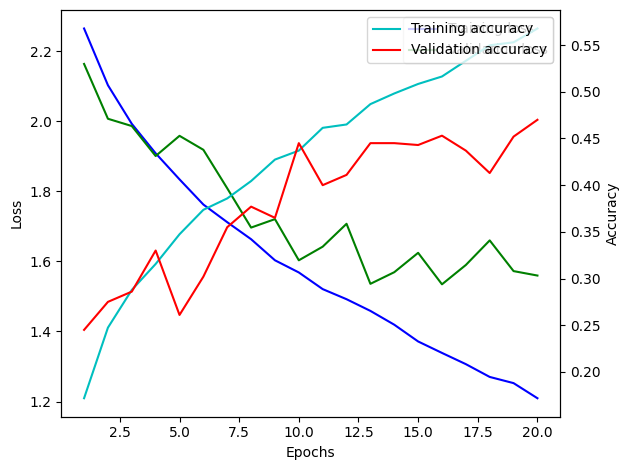

Epoch 1/20
157/157 [==============================] - 4s 21ms/step - loss: 2.1903 - acc: 0.1912 - val_loss: 2.1245 - val_acc: 0.2490
Epoch 2/20
154/157 [============================>.] - ETA: 0s - loss: 2.0624 - acc: 0.2504
Epoch 2: val_acc improved from -inf to 0.23800, saving model to my_model.h5
157/157 [==============================] - 3s 20ms/step - loss: 2.0607 - acc: 0.2506 - val_loss: 2.0939 - val_acc: 0.2380
Epoch 3/20
157/157 [==============================] - 4s 26ms/step - loss: 1.9767 - acc: 0.2868 - val_loss: 2.0068 - val_acc: 0.2930
Epoch 4/20
154/157 [============================>.] - ETA: 0s - loss: 1.8945 - acc: 0.3300
Epoch 4: val_acc improved from 0.23800 to 0.29800, saving model to my_model.h5
157/157 [==============================] - 3s 21ms/step - loss: 1.8936 - acc: 0.3310 - val_loss: 1.9281 - val_acc: 0.2980
Epoch 5/20
157/157 [==============================] - 3s 20ms/step - loss: 1.8165 - acc: 0.3496 - val_loss: 1.7922 - val_acc: 0.3550
Epoch 6/20
156/157 [

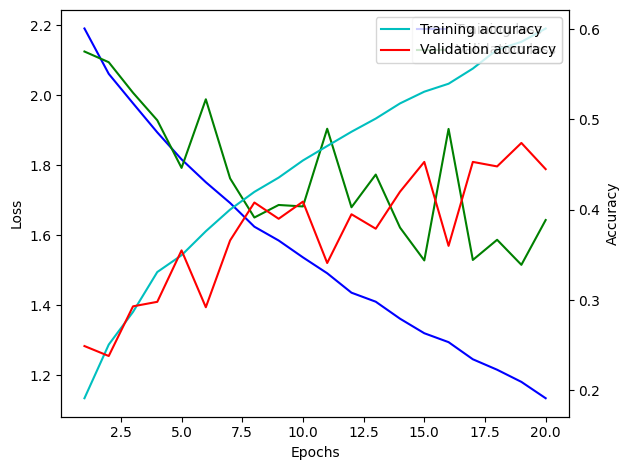

Epoch 1/20
157/157 [==============================] - 5s 27ms/step - loss: 2.2444 - acc: 0.1718 - val_loss: 2.1260 - val_acc: 0.2130
Epoch 2/20
154/157 [============================>.] - ETA: 0s - loss: 2.0981 - acc: 0.2480
Epoch 2: val_acc improved from -inf to 0.25000, saving model to my_model.h5
157/157 [==============================] - 3s 21ms/step - loss: 2.0972 - acc: 0.2480 - val_loss: 2.1228 - val_acc: 0.2500
Epoch 3/20
157/157 [==============================] - 3s 21ms/step - loss: 2.0199 - acc: 0.2750 - val_loss: 1.9634 - val_acc: 0.2980
Epoch 4/20
154/157 [============================>.] - ETA: 0s - loss: 1.9493 - acc: 0.3032
Epoch 4: val_acc improved from 0.25000 to 0.29000, saving model to my_model.h5
157/157 [==============================] - 4s 27ms/step - loss: 1.9485 - acc: 0.3044 - val_loss: 1.9635 - val_acc: 0.2900
Epoch 5/20
157/157 [==============================] - 3s 20ms/step - loss: 1.8819 - acc: 0.3350 - val_loss: 1.8665 - val_acc: 0.3330
Epoch 6/20
156/157 [

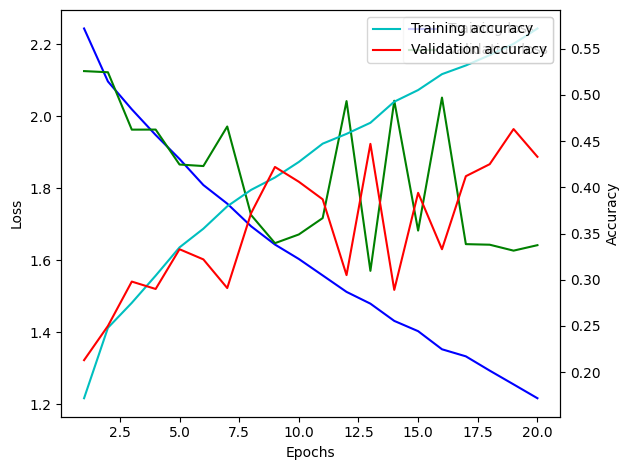

Epoch 1/20
157/157 [==============================] - 5s 26ms/step - loss: 2.2806 - acc: 0.1436 - val_loss: 2.2312 - val_acc: 0.1810
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 2.1375 - acc: 0.2298
Epoch 2: val_acc improved from -inf to 0.21600, saving model to my_model.h5
157/157 [==============================] - 3s 21ms/step - loss: 2.1363 - acc: 0.2308 - val_loss: 2.0674 - val_acc: 0.2160
Epoch 3/20
157/157 [==============================] - 3s 20ms/step - loss: 1.9936 - acc: 0.2832 - val_loss: 1.9428 - val_acc: 0.2980
Epoch 4/20
154/157 [============================>.] - ETA: 0s - loss: 1.8945 - acc: 0.3269
Epoch 4: val_acc improved from 0.21600 to 0.32900, saving model to my_model.h5
157/157 [==============================] - 3s 20ms/step - loss: 1.8953 - acc: 0.3254 - val_loss: 1.8580 - val_acc: 0.3290
Epoch 5/20
157/157 [==============================] - 4s 27ms/step - loss: 1.8154 - acc: 0.3552 - val_loss: 1.8311 - val_acc: 0.3150
Epoch 6/20
156/157 [

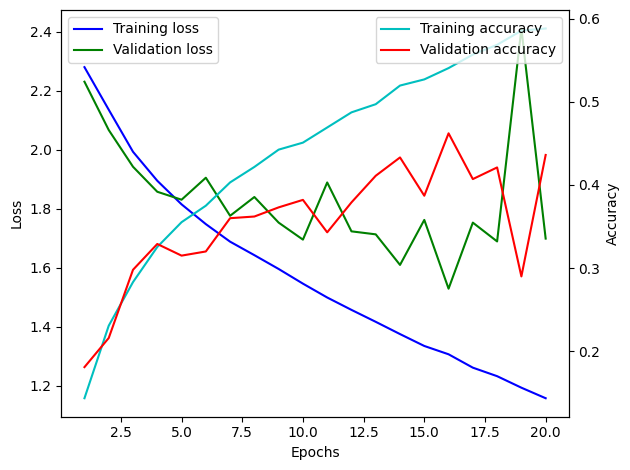

Epoch 1/20
157/157 [==============================] - 4s 22ms/step - loss: 2.2524 - acc: 0.1612 - val_loss: 2.1450 - val_acc: 0.2230
Epoch 2/20
154/157 [============================>.] - ETA: 0s - loss: 2.0652 - acc: 0.2606
Epoch 2: val_acc improved from -inf to 0.25200, saving model to my_model.h5
157/157 [==============================] - 4s 28ms/step - loss: 2.0626 - acc: 0.2622 - val_loss: 2.0324 - val_acc: 0.2520
Epoch 3/20
157/157 [==============================] - 3s 20ms/step - loss: 1.9442 - acc: 0.3110 - val_loss: 1.8934 - val_acc: 0.3480
Epoch 4/20
154/157 [============================>.] - ETA: 0s - loss: 1.8557 - acc: 0.3391
Epoch 4: val_acc improved from 0.25200 to 0.32300, saving model to my_model.h5
157/157 [==============================] - 3s 20ms/step - loss: 1.8540 - acc: 0.3408 - val_loss: 1.8564 - val_acc: 0.3230
Epoch 5/20
157/157 [==============================] - 3s 21ms/step - loss: 1.7745 - acc: 0.3690 - val_loss: 1.7523 - val_acc: 0.3740
Epoch 6/20
154/157 [

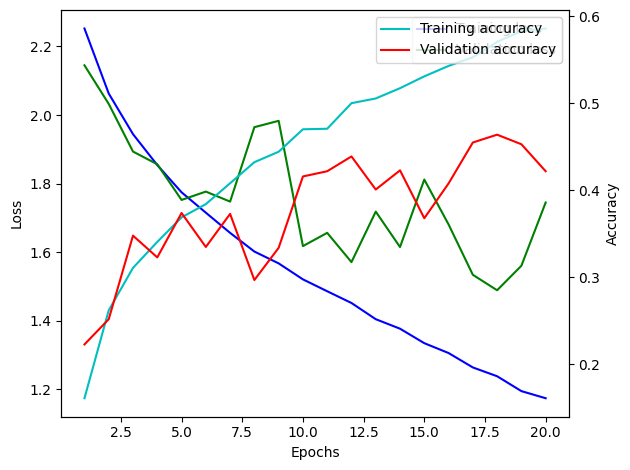

Epoch 1/20
157/157 [==============================] - 4s 22ms/step - loss: 2.2370 - acc: 0.1680 - val_loss: 2.1381 - val_acc: 0.1970
Epoch 2/20
154/157 [============================>.] - ETA: 0s - loss: 2.0603 - acc: 0.2603
Epoch 2: val_acc improved from -inf to 0.27400, saving model to my_model.h5
157/157 [==============================] - 3s 21ms/step - loss: 2.0583 - acc: 0.2604 - val_loss: 2.0207 - val_acc: 0.2740
Epoch 3/20
157/157 [==============================] - 4s 28ms/step - loss: 1.9643 - acc: 0.2970 - val_loss: 1.9780 - val_acc: 0.2800
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 1.8873 - acc: 0.3315
Epoch 4: val_acc improved from 0.27400 to 0.31400, saving model to my_model.h5
157/157 [==============================] - 3s 22ms/step - loss: 1.8886 - acc: 0.3304 - val_loss: 1.8662 - val_acc: 0.3140
Epoch 5/20
157/157 [==============================] - 3s 21ms/step - loss: 1.8227 - acc: 0.3584 - val_loss: 1.8515 - val_acc: 0.3330
Epoch 6/20
156/157 [

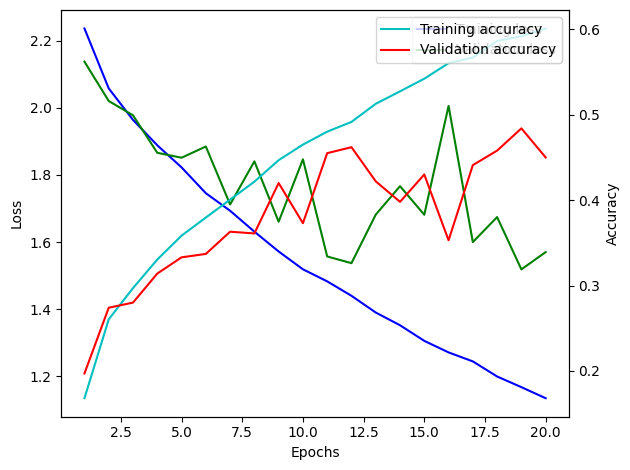

Epoch 1/20
157/157 [==============================] - 5s 23ms/step - loss: 2.1085 - acc: 0.2300 - val_loss: 1.8971 - val_acc: 0.3070
Epoch 2/20
154/157 [============================>.] - ETA: 0s - loss: 1.7884 - acc: 0.3673
Epoch 2: val_acc improved from -inf to 0.41400, saving model to my_model.h5
157/157 [==============================] - 3s 21ms/step - loss: 1.7852 - acc: 0.3692 - val_loss: 1.6376 - val_acc: 0.4140
Epoch 3/20
157/157 [==============================] - 4s 28ms/step - loss: 1.5856 - acc: 0.4378 - val_loss: 1.5106 - val_acc: 0.4550
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 1.4382 - acc: 0.4927
Epoch 4: val_acc improved from 0.41400 to 0.46700, saving model to my_model.h5
157/157 [==============================] - 3s 22ms/step - loss: 1.4391 - acc: 0.4922 - val_loss: 1.4850 - val_acc: 0.4670
Epoch 5/20
157/157 [==============================] - 3s 21ms/step - loss: 1.3285 - acc: 0.5276 - val_loss: 1.4647 - val_acc: 0.4870
Epoch 6/20
156/157 [

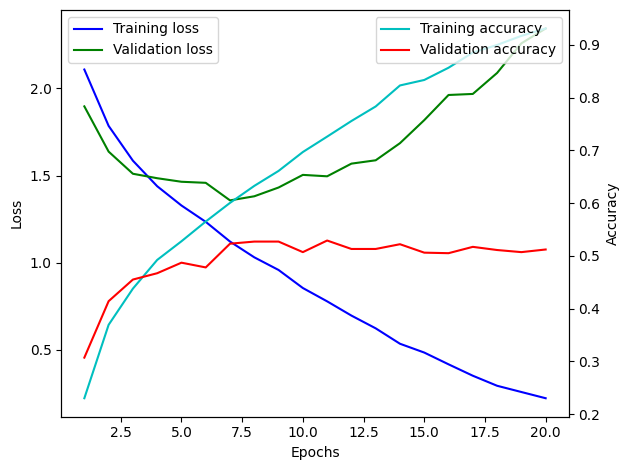

Epoch 1/20
157/157 [==============================] - 6s 29ms/step - loss: 2.0390 - acc: 0.2422 - val_loss: 1.7836 - val_acc: 0.3490
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 1.7148 - acc: 0.3732
Epoch 2: val_acc improved from -inf to 0.40400, saving model to my_model.h5
157/157 [==============================] - 3s 22ms/step - loss: 1.7148 - acc: 0.3728 - val_loss: 1.6429 - val_acc: 0.4040
Epoch 3/20
157/157 [==============================] - 3s 21ms/step - loss: 1.5272 - acc: 0.4524 - val_loss: 1.5157 - val_acc: 0.4640
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 1.3715 - acc: 0.5180
Epoch 4: val_acc improved from 0.40400 to 0.49500, saving model to my_model.h5
157/157 [==============================] - 4s 28ms/step - loss: 1.3715 - acc: 0.5180 - val_loss: 1.4294 - val_acc: 0.4950
Epoch 5/20
157/157 [==============================] - 3s 21ms/step - loss: 1.2561 - acc: 0.5596 - val_loss: 1.3754 - val_acc: 0.5130
Epoch 6/20
155/157 [

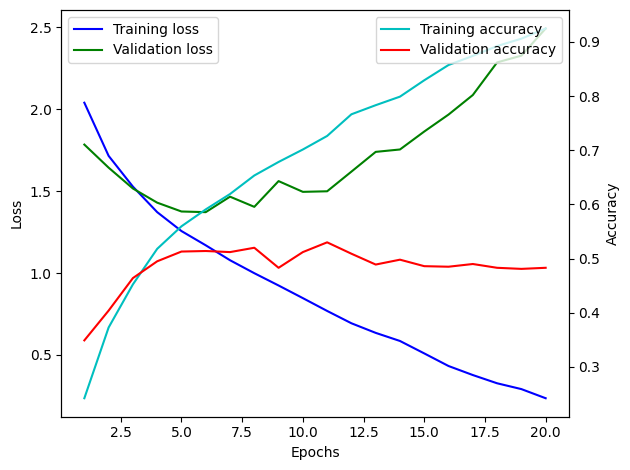

Epoch 1/20
157/157 [==============================] - 5s 24ms/step - loss: 2.0454 - acc: 0.2616 - val_loss: 1.8355 - val_acc: 0.3550
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 1.7153 - acc: 0.3984
Epoch 2: val_acc improved from -inf to 0.41000, saving model to my_model.h5
157/157 [==============================] - 4s 28ms/step - loss: 1.7141 - acc: 0.3988 - val_loss: 1.5791 - val_acc: 0.4100
Epoch 3/20
157/157 [==============================] - 3s 22ms/step - loss: 1.5182 - acc: 0.4548 - val_loss: 1.4434 - val_acc: 0.4870
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 1.4065 - acc: 0.5040
Epoch 4: val_acc improved from 0.41000 to 0.50000, saving model to my_model.h5
157/157 [==============================] - 3s 22ms/step - loss: 1.4069 - acc: 0.5042 - val_loss: 1.4085 - val_acc: 0.5000
Epoch 5/20
157/157 [==============================] - 4s 28ms/step - loss: 1.2832 - acc: 0.5520 - val_loss: 1.3996 - val_acc: 0.5020
Epoch 6/20
156/157 [

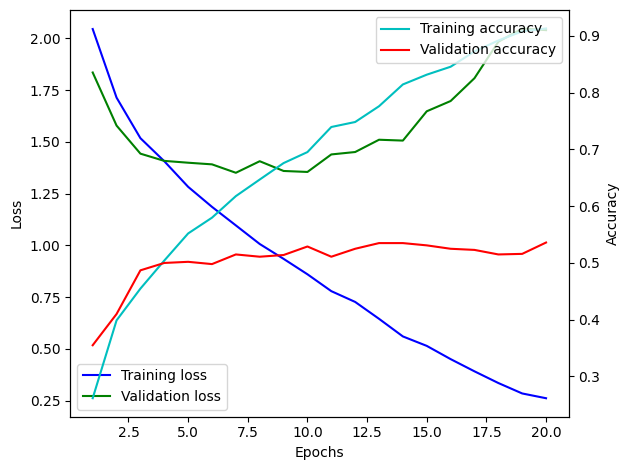

Epoch 1/20
157/157 [==============================] - 5s 26ms/step - loss: 2.0464 - acc: 0.2494 - val_loss: 1.7879 - val_acc: 0.3620
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 1.7281 - acc: 0.3800
Epoch 2: val_acc improved from -inf to 0.42800, saving model to my_model.h5
157/157 [==============================] - 4s 26ms/step - loss: 1.7289 - acc: 0.3800 - val_loss: 1.6333 - val_acc: 0.4280
Epoch 3/20
157/157 [==============================] - 3s 22ms/step - loss: 1.5761 - acc: 0.4428 - val_loss: 1.5642 - val_acc: 0.4320
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 1.4543 - acc: 0.4796
Epoch 4: val_acc improved from 0.42800 to 0.47300, saving model to my_model.h5
157/157 [==============================] - 4s 23ms/step - loss: 1.4545 - acc: 0.4792 - val_loss: 1.4696 - val_acc: 0.4730
Epoch 5/20
157/157 [==============================] - 5s 29ms/step - loss: 1.3450 - acc: 0.5170 - val_loss: 1.3958 - val_acc: 0.5010
Epoch 6/20
156/157 [

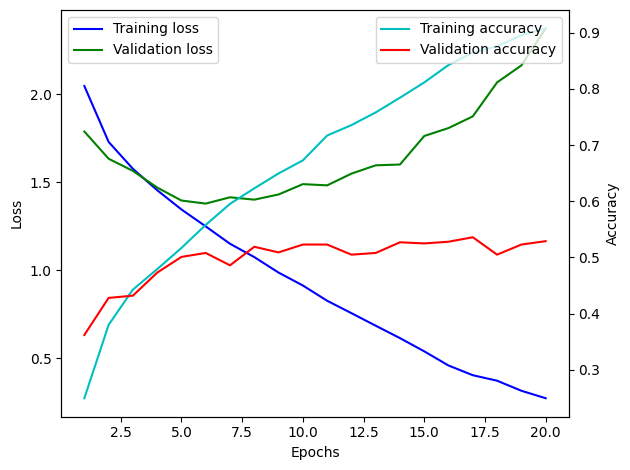

Epoch 1/20
157/157 [==============================] - 5s 29ms/step - loss: 3.9042 - acc: 0.1684 - val_loss: 3.7869 - val_acc: 0.2290
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 3.6598 - acc: 0.2442
Epoch 2: val_acc improved from -inf to 0.23000, saving model to my_model.h5
157/157 [==============================] - 3s 22ms/step - loss: 3.6598 - acc: 0.2442 - val_loss: 3.6019 - val_acc: 0.2300
Epoch 3/20
157/157 [==============================] - 4s 22ms/step - loss: 3.4690 - acc: 0.2804 - val_loss: 3.4787 - val_acc: 0.2280
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 3.3182 - acc: 0.3115
Epoch 4: val_acc improved from 0.23000 to 0.31700, saving model to my_model.h5
157/157 [==============================] - 4s 26ms/step - loss: 3.3172 - acc: 0.3112 - val_loss: 3.2508 - val_acc: 0.3170
Epoch 5/20
157/157 [==============================] - 4s 25ms/step - loss: 3.1704 - acc: 0.3392 - val_loss: 3.1325 - val_acc: 0.3190
Epoch 6/20
154/157 [

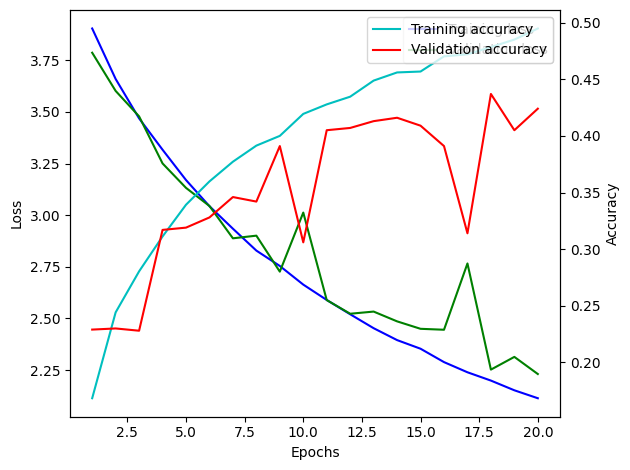

Epoch 1/20
157/157 [==============================] - 5s 31ms/step - loss: 3.8151 - acc: 0.1782 - val_loss: 3.6794 - val_acc: 0.2110
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 3.5925 - acc: 0.2410
Epoch 2: val_acc improved from -inf to 0.27600, saving model to my_model.h5
157/157 [==============================] - 4s 23ms/step - loss: 3.5917 - acc: 0.2412 - val_loss: 3.5000 - val_acc: 0.2760
Epoch 3/20
157/157 [==============================] - 4s 23ms/step - loss: 3.4264 - acc: 0.2854 - val_loss: 3.3685 - val_acc: 0.2710
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 3.2787 - acc: 0.3175
Epoch 4: val_acc improved from 0.27600 to 0.30700, saving model to my_model.h5
157/157 [==============================] - 5s 29ms/step - loss: 3.2779 - acc: 0.3178 - val_loss: 3.2580 - val_acc: 0.3070
Epoch 5/20
157/157 [==============================] - 4s 22ms/step - loss: 3.1448 - acc: 0.3450 - val_loss: 3.0971 - val_acc: 0.3430
Epoch 6/20
157/157 [

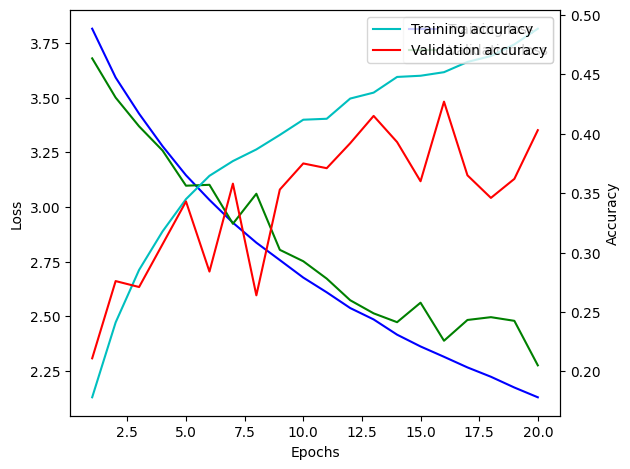

Epoch 1/20
157/157 [==============================] - 5s 24ms/step - loss: 3.8185 - acc: 0.1926 - val_loss: 3.6753 - val_acc: 0.2390
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 3.5885 - acc: 0.2628
Epoch 2: val_acc improved from -inf to 0.21100, saving model to my_model.h5
157/157 [==============================] - 4s 23ms/step - loss: 3.5882 - acc: 0.2628 - val_loss: 3.5885 - val_acc: 0.2110
Epoch 3/20
157/157 [==============================] - 4s 27ms/step - loss: 3.4255 - acc: 0.2982 - val_loss: 3.4046 - val_acc: 0.2600
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 3.2828 - acc: 0.3282
Epoch 4: val_acc improved from 0.21100 to 0.35000, saving model to my_model.h5
157/157 [==============================] - 4s 26ms/step - loss: 3.2828 - acc: 0.3282 - val_loss: 3.2154 - val_acc: 0.3500
Epoch 5/20
157/157 [==============================] - 4s 23ms/step - loss: 3.1547 - acc: 0.3452 - val_loss: 3.1085 - val_acc: 0.3400
Epoch 6/20
156/157 [

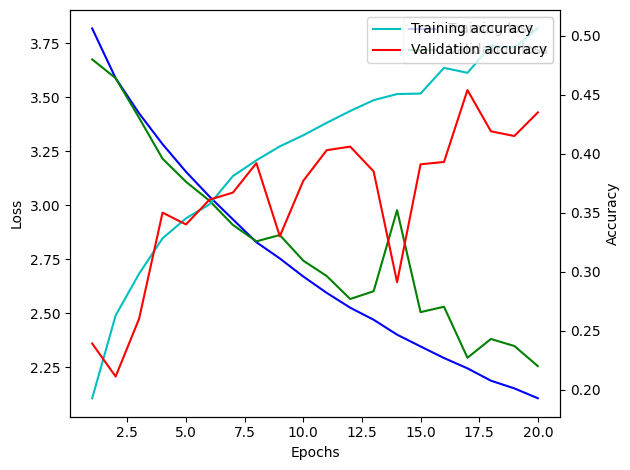

Epoch 1/20
157/157 [==============================] - 4s 25ms/step - loss: 3.8769 - acc: 0.1544 - val_loss: 3.7565 - val_acc: 0.1800
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 3.6192 - acc: 0.2601
Epoch 2: val_acc improved from -inf to 0.26100, saving model to my_model.h5
157/157 [==============================] - 4s 23ms/step - loss: 3.6161 - acc: 0.2614 - val_loss: 3.5474 - val_acc: 0.2610
Epoch 3/20
157/157 [==============================] - 5s 30ms/step - loss: 3.4205 - acc: 0.3020 - val_loss: 3.3578 - val_acc: 0.2930
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 3.2695 - acc: 0.3271
Epoch 4: val_acc improved from 0.26100 to 0.31600, saving model to my_model.h5
157/157 [==============================] - 4s 23ms/step - loss: 3.2696 - acc: 0.3270 - val_loss: 3.2445 - val_acc: 0.3160
Epoch 5/20
157/157 [==============================] - 4s 23ms/step - loss: 3.1357 - acc: 0.3598 - val_loss: 3.0798 - val_acc: 0.3720
Epoch 6/20
156/157 [

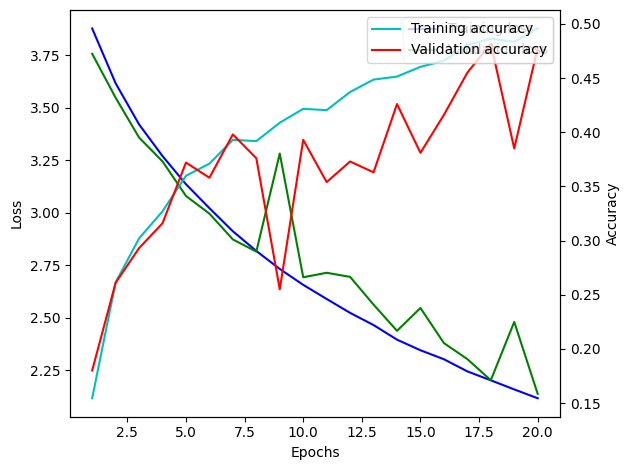

Epoch 1/20
157/157 [==============================] - 4s 24ms/step - loss: 3.9047 - acc: 0.1432 - val_loss: 3.8171 - val_acc: 0.1610
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 3.7051 - acc: 0.2075
Epoch 2: val_acc improved from -inf to 0.21100, saving model to my_model.h5
157/157 [==============================] - 5s 30ms/step - loss: 3.7032 - acc: 0.2076 - val_loss: 3.6111 - val_acc: 0.2110
Epoch 3/20
157/157 [==============================] - 4s 23ms/step - loss: 3.5057 - acc: 0.2532 - val_loss: 3.4201 - val_acc: 0.3040
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 3.3478 - acc: 0.2879
Epoch 4: val_acc did not improve from 0.21100
157/157 [==============================] - 4s 24ms/step - loss: 3.3480 - acc: 0.2878 - val_loss: 3.4654 - val_acc: 0.2070
Epoch 5/20
157/157 [==============================] - 4s 28ms/step - loss: 3.2164 - acc: 0.3164 - val_loss: 3.3546 - val_acc: 0.2620
Epoch 6/20
156/157 [============================>.] -

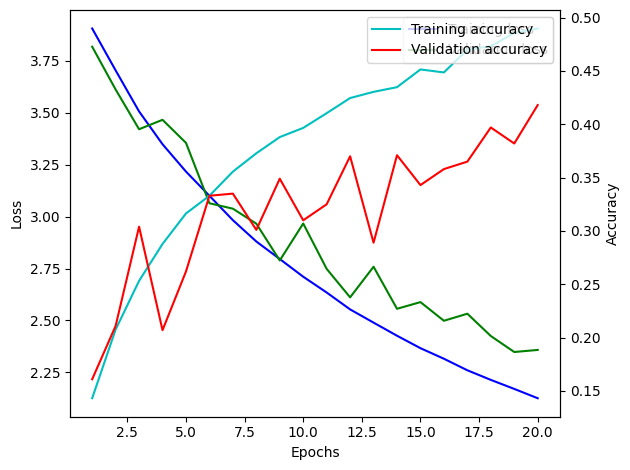

Epoch 1/20
157/157 [==============================] - 5s 26ms/step - loss: 3.9047 - acc: 0.1324 - val_loss: 3.7927 - val_acc: 0.1920
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 3.6830 - acc: 0.2206
Epoch 2: val_acc improved from -inf to 0.23700, saving model to my_model.h5
157/157 [==============================] - 4s 22ms/step - loss: 3.6816 - acc: 0.2214 - val_loss: 3.5375 - val_acc: 0.2370
Epoch 3/20
157/157 [==============================] - 4s 25ms/step - loss: 3.4661 - acc: 0.2756 - val_loss: 3.3988 - val_acc: 0.2660
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 3.3080 - acc: 0.3087
Epoch 4: val_acc improved from 0.23700 to 0.30100, saving model to my_model.h5
157/157 [==============================] - 4s 27ms/step - loss: 3.3081 - acc: 0.3088 - val_loss: 3.2623 - val_acc: 0.3010
Epoch 5/20
157/157 [==============================] - 3s 22ms/step - loss: 3.1734 - acc: 0.3332 - val_loss: 3.1085 - val_acc: 0.3340
Epoch 6/20
155/157 [

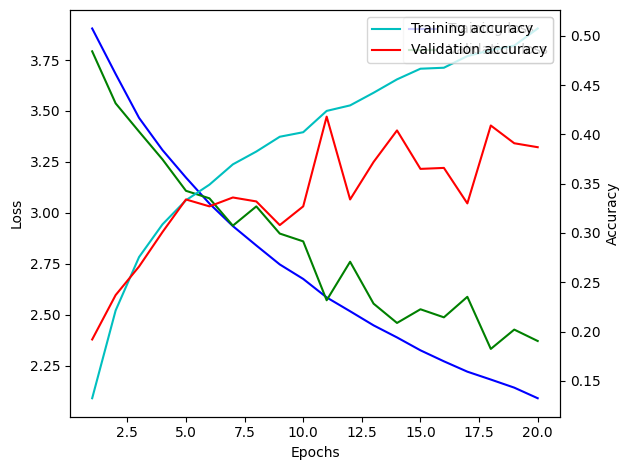

Epoch 1/20
157/157 [==============================] - 4s 24ms/step - loss: 3.8788 - acc: 0.1504 - val_loss: 3.7463 - val_acc: 0.2240
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 3.6688 - acc: 0.2210
Epoch 2: val_acc improved from -inf to 0.26400, saving model to my_model.h5
157/157 [==============================] - 4s 23ms/step - loss: 3.6690 - acc: 0.2206 - val_loss: 3.5674 - val_acc: 0.2640
Epoch 3/20
157/157 [==============================] - 5s 29ms/step - loss: 3.4793 - acc: 0.2778 - val_loss: 3.4137 - val_acc: 0.2700
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 3.2977 - acc: 0.3230
Epoch 4: val_acc improved from 0.26400 to 0.31000, saving model to my_model.h5
157/157 [==============================] - 4s 23ms/step - loss: 3.2977 - acc: 0.3230 - val_loss: 3.3389 - val_acc: 0.3100
Epoch 5/20
157/157 [==============================] - 4s 23ms/step - loss: 3.1476 - acc: 0.3480 - val_loss: 3.1885 - val_acc: 0.3230
Epoch 6/20
156/157 [

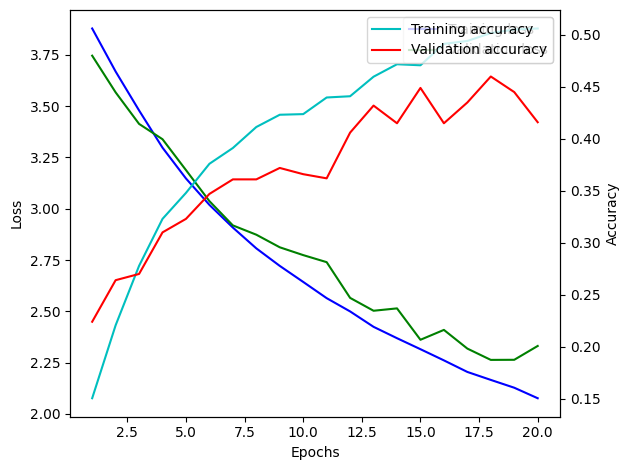

Epoch 1/20
157/157 [==============================] - 5s 27ms/step - loss: 3.8691 - acc: 0.1646 - val_loss: 3.7112 - val_acc: 0.2150
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 3.6211 - acc: 0.2498
Epoch 2: val_acc improved from -inf to 0.24600, saving model to my_model.h5
157/157 [==============================] - 4s 26ms/step - loss: 3.6213 - acc: 0.2496 - val_loss: 3.5544 - val_acc: 0.2460
Epoch 3/20
157/157 [==============================] - 4s 23ms/step - loss: 3.4478 - acc: 0.2854 - val_loss: 3.3880 - val_acc: 0.2790
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 3.3090 - acc: 0.3117
Epoch 4: val_acc improved from 0.24600 to 0.28500, saving model to my_model.h5
157/157 [==============================] - 4s 23ms/step - loss: 3.3087 - acc: 0.3116 - val_loss: 3.3343 - val_acc: 0.2850
Epoch 5/20
157/157 [==============================] - 5s 30ms/step - loss: 3.1784 - acc: 0.3370 - val_loss: 3.4594 - val_acc: 0.2260
Epoch 6/20
157/157 [

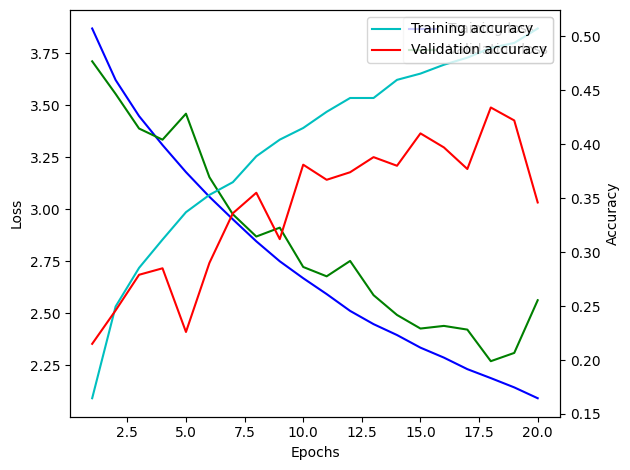

Epoch 1/20
157/157 [==============================] - 6s 29ms/step - loss: 3.0553 - acc: 0.2346 - val_loss: 2.5125 - val_acc: 0.3450
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 2.3408 - acc: 0.3419
Epoch 2: val_acc improved from -inf to 0.34100, saving model to my_model.h5
157/157 [==============================] - 4s 23ms/step - loss: 2.3403 - acc: 0.3422 - val_loss: 2.1806 - val_acc: 0.3410
Epoch 3/20
157/157 [==============================] - 4s 23ms/step - loss: 2.1069 - acc: 0.3902 - val_loss: 2.0510 - val_acc: 0.3760
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 2.0131 - acc: 0.4016
Epoch 4: val_acc improved from 0.34100 to 0.39600, saving model to my_model.h5
157/157 [==============================] - 5s 30ms/step - loss: 2.0109 - acc: 0.4024 - val_loss: 2.0533 - val_acc: 0.3960
Epoch 5/20
157/157 [==============================] - 4s 23ms/step - loss: 1.9039 - acc: 0.4438 - val_loss: 1.8704 - val_acc: 0.4590
Epoch 6/20
156/157 [

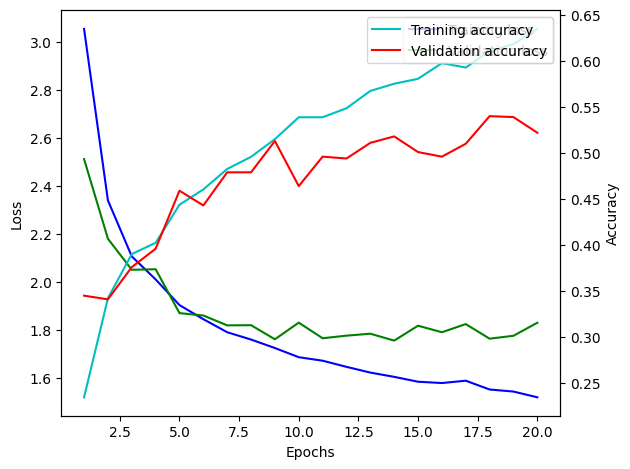

Epoch 1/20
157/157 [==============================] - 5s 25ms/step - loss: 2.9936 - acc: 0.2508 - val_loss: 2.4715 - val_acc: 0.3300
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 2.3122 - acc: 0.3624
Epoch 2: val_acc improved from -inf to 0.38700, saving model to my_model.h5
157/157 [==============================] - 4s 23ms/step - loss: 2.3122 - acc: 0.3624 - val_loss: 2.1491 - val_acc: 0.3870
Epoch 3/20
157/157 [==============================] - 5s 30ms/step - loss: 2.1153 - acc: 0.4086 - val_loss: 2.0793 - val_acc: 0.3750
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 1.9905 - acc: 0.4325
Epoch 4: val_acc improved from 0.38700 to 0.43900, saving model to my_model.h5
157/157 [==============================] - 4s 24ms/step - loss: 1.9899 - acc: 0.4326 - val_loss: 1.9539 - val_acc: 0.4390
Epoch 5/20
157/157 [==============================] - 4s 23ms/step - loss: 1.9188 - acc: 0.4488 - val_loss: 1.9402 - val_acc: 0.4320
Epoch 6/20
156/157 [

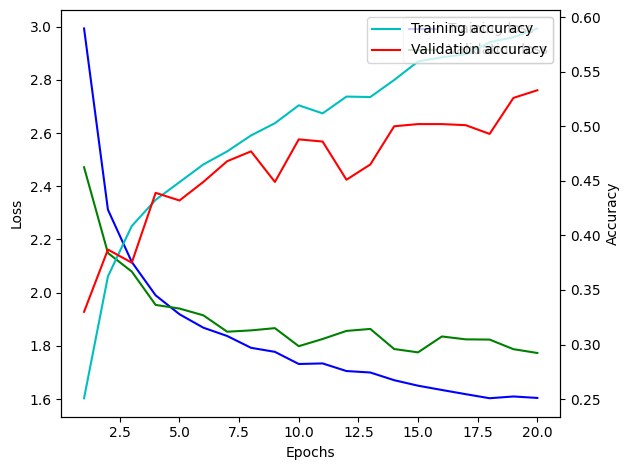

Epoch 1/20
157/157 [==============================] - 6s 30ms/step - loss: 2.9651 - acc: 0.2144 - val_loss: 2.4224 - val_acc: 0.3050
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 2.2808 - acc: 0.3285
Epoch 2: val_acc improved from -inf to 0.36900, saving model to my_model.h5
157/157 [==============================] - 4s 26ms/step - loss: 2.2810 - acc: 0.3284 - val_loss: 2.1322 - val_acc: 0.3690
Epoch 3/20
157/157 [==============================] - 4s 24ms/step - loss: 2.0797 - acc: 0.3790 - val_loss: 1.9759 - val_acc: 0.4130
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 1.9685 - acc: 0.4199
Epoch 4: val_acc improved from 0.36900 to 0.43100, saving model to my_model.h5
157/157 [==============================] - 4s 27ms/step - loss: 1.9681 - acc: 0.4200 - val_loss: 1.9238 - val_acc: 0.4310
Epoch 5/20
157/157 [==============================] - 4s 28ms/step - loss: 1.9182 - acc: 0.4200 - val_loss: 1.8312 - val_acc: 0.4500
Epoch 6/20
155/157 [

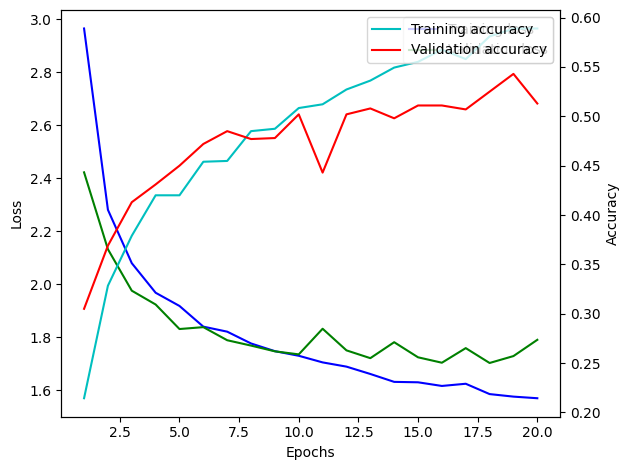

Epoch 1/20
157/157 [==============================] - 5s 26ms/step - loss: 3.0054 - acc: 0.2260 - val_loss: 2.4368 - val_acc: 0.3490
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 2.3051 - acc: 0.3456
Epoch 2: val_acc improved from -inf to 0.37200, saving model to my_model.h5
157/157 [==============================] - 5s 32ms/step - loss: 2.3051 - acc: 0.3456 - val_loss: 2.1411 - val_acc: 0.3720
Epoch 3/20
157/157 [==============================] - 4s 24ms/step - loss: 2.0867 - acc: 0.3940 - val_loss: 1.9959 - val_acc: 0.4180
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 1.9947 - acc: 0.4284
Epoch 4: val_acc improved from 0.37200 to 0.43800, saving model to my_model.h5
157/157 [==============================] - 4s 24ms/step - loss: 1.9950 - acc: 0.4272 - val_loss: 1.9259 - val_acc: 0.4380
Epoch 5/20
157/157 [==============================] - 5s 31ms/step - loss: 1.9043 - acc: 0.4472 - val_loss: 1.8808 - val_acc: 0.4430
Epoch 6/20
155/157 [

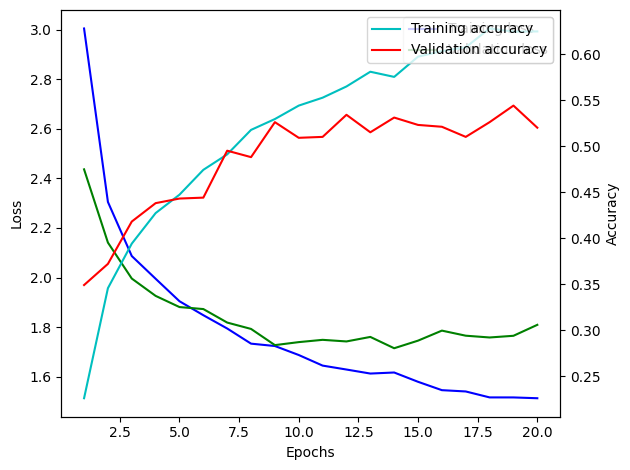

Epoch 1/20
157/157 [==============================] - 5s 25ms/step - loss: 5.4201 - acc: 0.1552 - val_loss: 5.1535 - val_acc: 0.2080
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 4.9251 - acc: 0.2310
Epoch 2: val_acc improved from -inf to 0.29600, saving model to my_model.h5
157/157 [==============================] - 4s 27ms/step - loss: 4.9252 - acc: 0.2306 - val_loss: 4.6742 - val_acc: 0.2960
Epoch 3/20
157/157 [==============================] - 4s 28ms/step - loss: 4.5062 - acc: 0.2772 - val_loss: 4.3049 - val_acc: 0.2830
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.1613 - acc: 0.3093
Epoch 4: val_acc did not improve from 0.29600
157/157 [==============================] - 4s 24ms/step - loss: 4.1613 - acc: 0.3090 - val_loss: 4.0452 - val_acc: 0.2920
Epoch 5/20
157/157 [==============================] - 4s 27ms/step - loss: 3.8612 - acc: 0.3292 - val_loss: 3.7552 - val_acc: 0.3170
Epoch 6/20
156/157 [============================>.] -

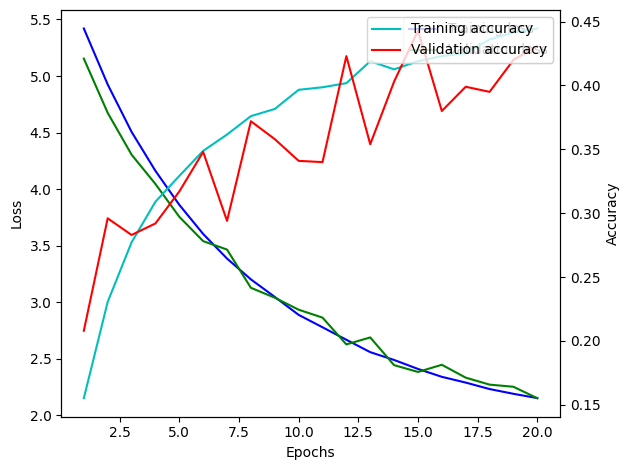

Epoch 1/20
157/157 [==============================] - 6s 32ms/step - loss: 5.4413 - acc: 0.1252 - val_loss: 5.2228 - val_acc: 0.1370
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 5.0028 - acc: 0.1973
Epoch 2: val_acc improved from -inf to 0.22400, saving model to my_model.h5
157/157 [==============================] - 4s 24ms/step - loss: 5.0023 - acc: 0.1974 - val_loss: 4.7787 - val_acc: 0.2240
Epoch 3/20
157/157 [==============================] - 4s 24ms/step - loss: 4.5770 - acc: 0.2476 - val_loss: 4.4208 - val_acc: 0.2550
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.2311 - acc: 0.2786
Epoch 4: val_acc did not improve from 0.22400
157/157 [==============================] - 5s 30ms/step - loss: 4.2296 - acc: 0.2786 - val_loss: 4.2593 - val_acc: 0.1770
Epoch 5/20
157/157 [==============================] - 4s 25ms/step - loss: 3.9494 - acc: 0.2896 - val_loss: 3.8849 - val_acc: 0.2680
Epoch 6/20
156/157 [============================>.] -

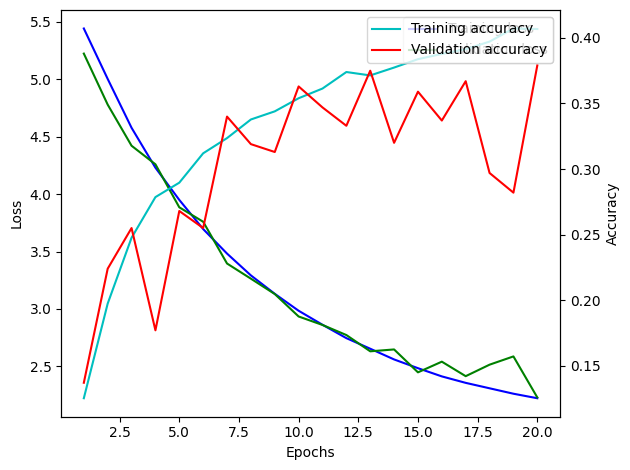

Epoch 1/20
157/157 [==============================] - 5s 25ms/step - loss: 5.3820 - acc: 0.1698 - val_loss: 5.1133 - val_acc: 0.2060
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 4.8753 - acc: 0.2484
Epoch 2: val_acc improved from -inf to 0.24000, saving model to my_model.h5
157/157 [==============================] - 4s 25ms/step - loss: 4.8750 - acc: 0.2482 - val_loss: 4.6759 - val_acc: 0.2400
Epoch 3/20
157/157 [==============================] - 5s 31ms/step - loss: 4.4840 - acc: 0.2830 - val_loss: 4.3463 - val_acc: 0.2740
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 4.1547 - acc: 0.3117
Epoch 4: val_acc improved from 0.24000 to 0.30900, saving model to my_model.h5
157/157 [==============================] - 4s 25ms/step - loss: 4.1548 - acc: 0.3116 - val_loss: 4.0180 - val_acc: 0.3090
Epoch 5/20
157/157 [==============================] - 4s 24ms/step - loss: 3.8666 - acc: 0.3270 - val_loss: 3.7598 - val_acc: 0.3180
Epoch 6/20
156/157 [

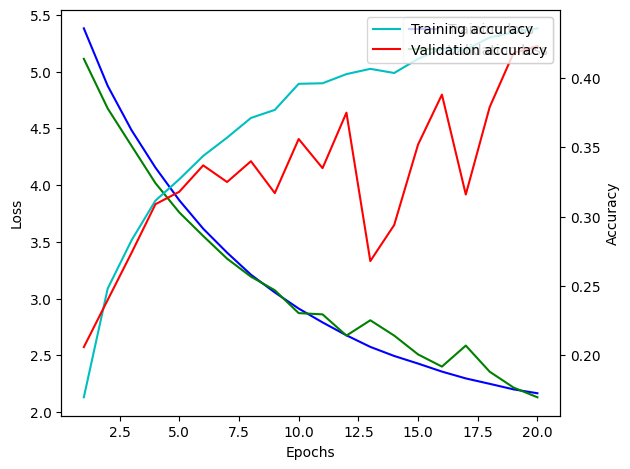

Epoch 1/20
157/157 [==============================] - 6s 33ms/step - loss: 5.4062 - acc: 0.1600 - val_loss: 5.1317 - val_acc: 0.1960
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 4.9071 - acc: 0.2298
Epoch 2: val_acc improved from -inf to 0.20600, saving model to my_model.h5
157/157 [==============================] - 4s 25ms/step - loss: 4.9070 - acc: 0.2296 - val_loss: 4.7393 - val_acc: 0.2060
Epoch 3/20
157/157 [==============================] - 4s 24ms/step - loss: 4.5280 - acc: 0.2538 - val_loss: 4.4226 - val_acc: 0.1970
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 4.2108 - acc: 0.2806
Epoch 4: val_acc improved from 0.20600 to 0.25500, saving model to my_model.h5
157/157 [==============================] - 5s 30ms/step - loss: 4.2106 - acc: 0.2804 - val_loss: 4.1108 - val_acc: 0.2550
Epoch 5/20
157/157 [==============================] - 4s 26ms/step - loss: 3.9289 - acc: 0.2986 - val_loss: 3.9762 - val_acc: 0.2020
Epoch 6/20
155/157 [

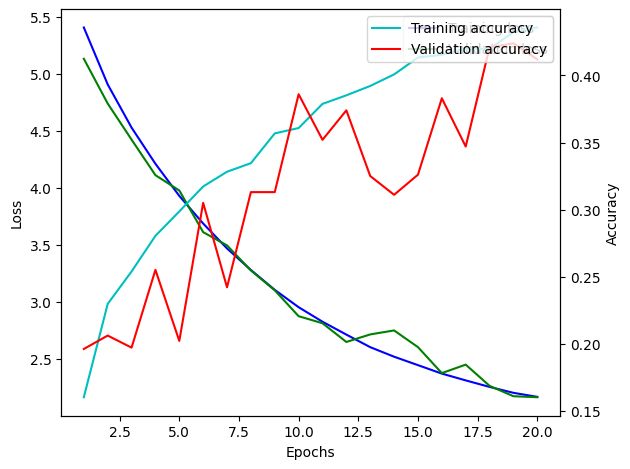

Epoch 1/20
157/157 [==============================] - 5s 27ms/step - loss: 5.3952 - acc: 0.1462 - val_loss: 5.1457 - val_acc: 0.2040
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 4.8942 - acc: 0.2442
Epoch 2: val_acc improved from -inf to 0.25900, saving model to my_model.h5
157/157 [==============================] - 5s 33ms/step - loss: 4.8932 - acc: 0.2434 - val_loss: 4.6735 - val_acc: 0.2590
Epoch 3/20
157/157 [==============================] - 4s 25ms/step - loss: 4.4857 - acc: 0.2742 - val_loss: 4.3909 - val_acc: 0.2630
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.1621 - acc: 0.2976
Epoch 4: val_acc did not improve from 0.25900
157/157 [==============================] - 4s 25ms/step - loss: 4.1619 - acc: 0.2972 - val_loss: 4.1940 - val_acc: 0.2070
Epoch 5/20
157/157 [==============================] - 5s 33ms/step - loss: 3.8833 - acc: 0.3124 - val_loss: 3.8387 - val_acc: 0.2530
Epoch 6/20
157/157 [==============================] -

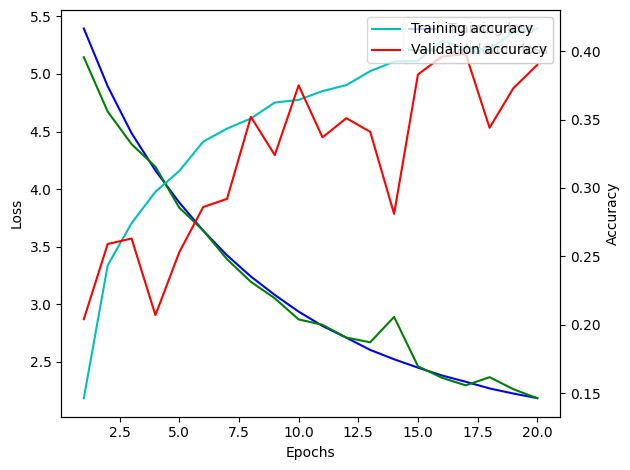

Epoch 1/20
157/157 [==============================] - 5s 27ms/step - loss: 5.3682 - acc: 0.1740 - val_loss: 5.1053 - val_acc: 0.1830
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 4.8802 - acc: 0.2410
Epoch 2: val_acc improved from -inf to 0.22300, saving model to my_model.h5
157/157 [==============================] - 4s 26ms/step - loss: 4.8796 - acc: 0.2412 - val_loss: 4.7049 - val_acc: 0.2230
Epoch 3/20
157/157 [==============================] - 5s 33ms/step - loss: 4.5057 - acc: 0.2658 - val_loss: 4.3736 - val_acc: 0.2360
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.1819 - acc: 0.2917
Epoch 4: val_acc improved from 0.22300 to 0.26100, saving model to my_model.h5
157/157 [==============================] - 4s 26ms/step - loss: 4.1819 - acc: 0.2908 - val_loss: 4.0731 - val_acc: 0.2610
Epoch 5/20
157/157 [==============================] - 4s 26ms/step - loss: 3.8898 - acc: 0.3212 - val_loss: 3.7645 - val_acc: 0.3070
Epoch 6/20
156/157 [

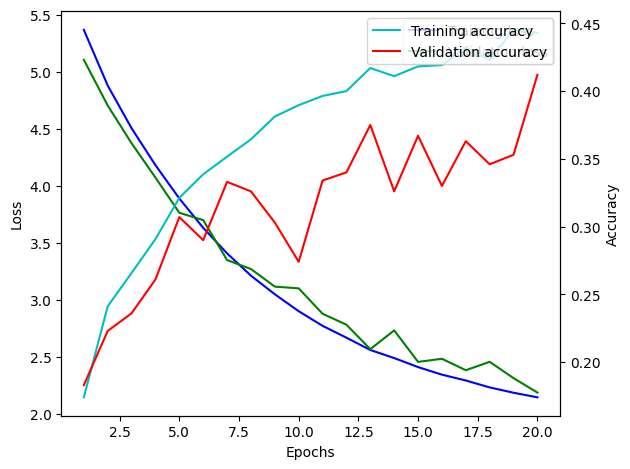

Epoch 1/20
157/157 [==============================] - 6s 35ms/step - loss: 5.3457 - acc: 0.1638 - val_loss: 5.0791 - val_acc: 0.2230
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 4.8497 - acc: 0.2356
Epoch 2: val_acc improved from -inf to 0.25600, saving model to my_model.h5
157/157 [==============================] - 4s 27ms/step - loss: 4.8497 - acc: 0.2356 - val_loss: 4.6693 - val_acc: 0.2560
Epoch 3/20
157/157 [==============================] - 4s 27ms/step - loss: 4.4722 - acc: 0.2708 - val_loss: 4.2993 - val_acc: 0.3150
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 4.1539 - acc: 0.3095
Epoch 4: val_acc improved from 0.25600 to 0.27100, saving model to my_model.h5
157/157 [==============================] - 5s 34ms/step - loss: 4.1536 - acc: 0.3096 - val_loss: 4.0423 - val_acc: 0.2710
Epoch 5/20
157/157 [==============================] - 4s 26ms/step - loss: 3.8749 - acc: 0.3188 - val_loss: 3.7871 - val_acc: 0.3100
Epoch 6/20
155/157 [

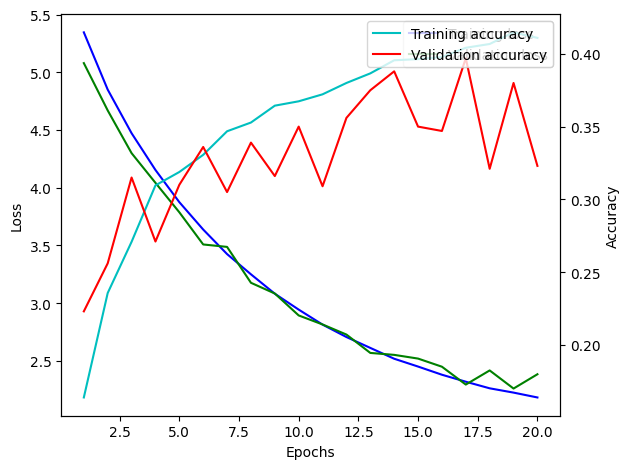

Epoch 1/20
157/157 [==============================] - 5s 28ms/step - loss: 5.3961 - acc: 0.1632 - val_loss: 5.1200 - val_acc: 0.2270
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 4.8873 - acc: 0.2411
Epoch 2: val_acc improved from -inf to 0.23500, saving model to my_model.h5
157/157 [==============================] - 4s 28ms/step - loss: 4.8849 - acc: 0.2420 - val_loss: 4.6892 - val_acc: 0.2350
Epoch 3/20
157/157 [==============================] - 5s 34ms/step - loss: 4.4763 - acc: 0.2834 - val_loss: 4.3452 - val_acc: 0.3050
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.1496 - acc: 0.3008
Epoch 4: val_acc improved from 0.23500 to 0.28700, saving model to my_model.h5
157/157 [==============================] - 4s 28ms/step - loss: 4.1489 - acc: 0.3000 - val_loss: 4.0231 - val_acc: 0.2870
Epoch 5/20
157/157 [==============================] - 4s 27ms/step - loss: 3.8743 - acc: 0.3222 - val_loss: 3.7718 - val_acc: 0.3450
Epoch 6/20
155/157 [

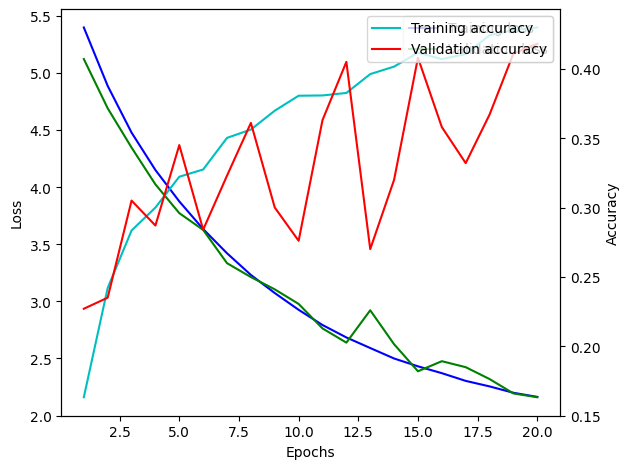

Epoch 1/20
157/157 [==============================] - 6s 30ms/step - loss: 3.5877 - acc: 0.2282 - val_loss: 2.6352 - val_acc: 0.3440
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 2.4670 - acc: 0.3140
Epoch 2: val_acc improved from -inf to 0.37100, saving model to my_model.h5
157/157 [==============================] - 5s 32ms/step - loss: 2.4670 - acc: 0.3140 - val_loss: 2.2810 - val_acc: 0.3710
Epoch 3/20
157/157 [==============================] - 5s 31ms/step - loss: 2.2252 - acc: 0.3398 - val_loss: 2.1118 - val_acc: 0.3930
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 2.1237 - acc: 0.3655
Epoch 4: val_acc did not improve from 0.37100
157/157 [==============================] - 4s 28ms/step - loss: 2.1238 - acc: 0.3656 - val_loss: 2.1426 - val_acc: 0.3560
Epoch 5/20
157/157 [==============================] - 5s 33ms/step - loss: 2.0797 - acc: 0.3624 - val_loss: 2.0178 - val_acc: 0.4010
Epoch 6/20
155/157 [============================>.] -

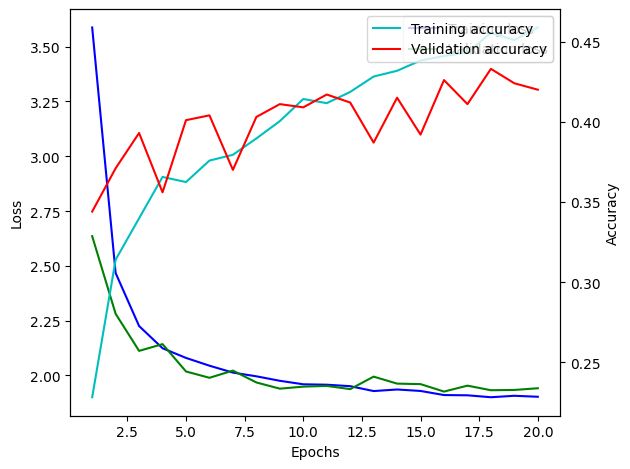

Epoch 1/20
157/157 [==============================] - 6s 33ms/step - loss: 3.5115 - acc: 0.2392 - val_loss: 2.5980 - val_acc: 0.3240
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 2.4121 - acc: 0.3214
Epoch 2: val_acc improved from -inf to 0.36100, saving model to my_model.h5
157/157 [==============================] - 5s 32ms/step - loss: 2.4123 - acc: 0.3208 - val_loss: 2.2607 - val_acc: 0.3610
Epoch 3/20
157/157 [==============================] - 5s 29ms/step - loss: 2.2120 - acc: 0.3504 - val_loss: 2.1041 - val_acc: 0.3760
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 2.1177 - acc: 0.3682
Epoch 4: val_acc improved from 0.36100 to 0.38300, saving model to my_model.h5
157/157 [==============================] - 6s 35ms/step - loss: 2.1176 - acc: 0.3684 - val_loss: 2.0602 - val_acc: 0.3830
Epoch 5/20
157/157 [==============================] - 5s 29ms/step - loss: 2.0760 - acc: 0.3770 - val_loss: 1.9766 - val_acc: 0.4150
Epoch 6/20
156/157 [

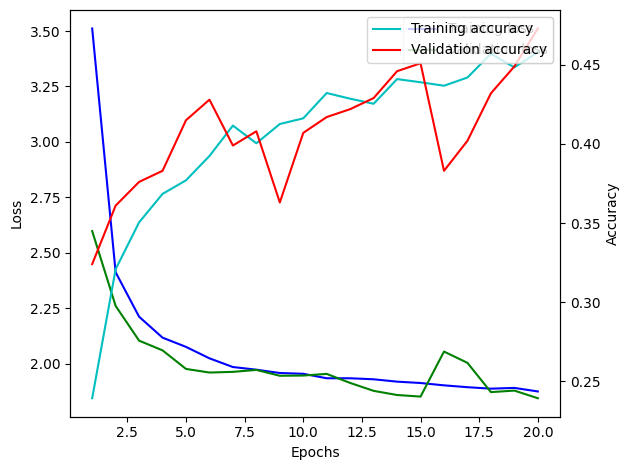

Epoch 1/20
157/157 [==============================] - 6s 30ms/step - loss: 3.5205 - acc: 0.2140 - val_loss: 2.5678 - val_acc: 0.3270
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 2.4159 - acc: 0.2997
Epoch 2: val_acc improved from -inf to 0.30800, saving model to my_model.h5
157/157 [==============================] - 5s 33ms/step - loss: 2.4155 - acc: 0.3000 - val_loss: 2.2585 - val_acc: 0.3080
Epoch 3/20
157/157 [==============================] - 5s 32ms/step - loss: 2.1837 - acc: 0.3384 - val_loss: 2.0986 - val_acc: 0.3390
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 2.1223 - acc: 0.3478
Epoch 4: val_acc improved from 0.30800 to 0.37000, saving model to my_model.h5
157/157 [==============================] - 5s 29ms/step - loss: 2.1216 - acc: 0.3478 - val_loss: 2.0518 - val_acc: 0.3700
Epoch 5/20
157/157 [==============================] - 6s 37ms/step - loss: 2.0449 - acc: 0.3730 - val_loss: 2.0344 - val_acc: 0.3560
Epoch 6/20
155/157 [

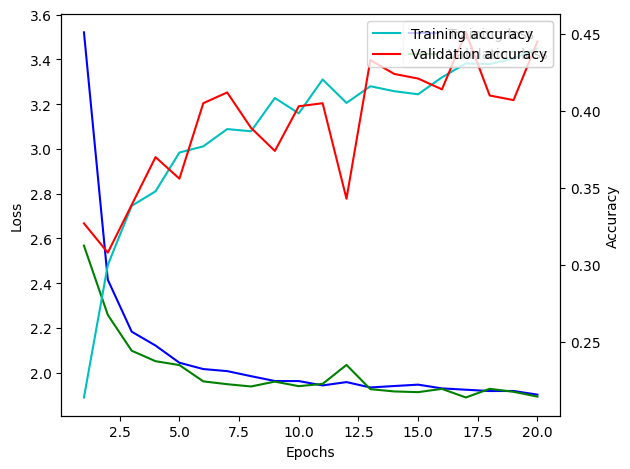

Epoch 1/20
157/157 [==============================] - 7s 35ms/step - loss: 3.3948 - acc: 0.1994 - val_loss: 2.4713 - val_acc: 0.2810
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 2.3380 - acc: 0.2831
Epoch 2: val_acc improved from -inf to 0.33800, saving model to my_model.h5
157/157 [==============================] - 5s 32ms/step - loss: 2.3362 - acc: 0.2836 - val_loss: 2.2013 - val_acc: 0.3380
Epoch 3/20
157/157 [==============================] - 5s 29ms/step - loss: 2.1491 - acc: 0.3332 - val_loss: 2.1101 - val_acc: 0.3350
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 2.0663 - acc: 0.3584
Epoch 4: val_acc improved from 0.33800 to 0.38100, saving model to my_model.h5
157/157 [==============================] - 6s 37ms/step - loss: 2.0663 - acc: 0.3584 - val_loss: 2.0276 - val_acc: 0.3810
Epoch 5/20
157/157 [==============================] - 5s 29ms/step - loss: 2.0170 - acc: 0.3712 - val_loss: 1.9883 - val_acc: 0.3850
Epoch 6/20
156/157 [

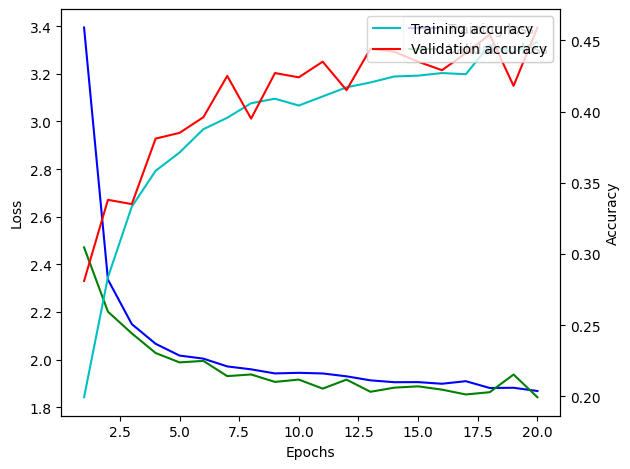

Epoch 1/20
157/157 [==============================] - 6s 36ms/step - loss: 6.8625 - acc: 0.1452 - val_loss: 6.3835 - val_acc: 0.2000
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 5.9919 - acc: 0.2242
Epoch 2: val_acc improved from -inf to 0.25700, saving model to my_model.h5
157/157 [==============================] - 4s 29ms/step - loss: 5.9911 - acc: 0.2242 - val_loss: 5.5721 - val_acc: 0.2570
Epoch 3/20
157/157 [==============================] - 5s 29ms/step - loss: 5.2541 - acc: 0.2668 - val_loss: 4.9670 - val_acc: 0.2660
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.6846 - acc: 0.2954
Epoch 4: val_acc improved from 0.25700 to 0.27400, saving model to my_model.h5
157/157 [==============================] - 6s 36ms/step - loss: 4.6828 - acc: 0.2952 - val_loss: 4.4433 - val_acc: 0.2740
Epoch 5/20
157/157 [==============================] - 5s 29ms/step - loss: 4.2173 - acc: 0.3112 - val_loss: 4.0325 - val_acc: 0.2990
Epoch 6/20
156/157 [

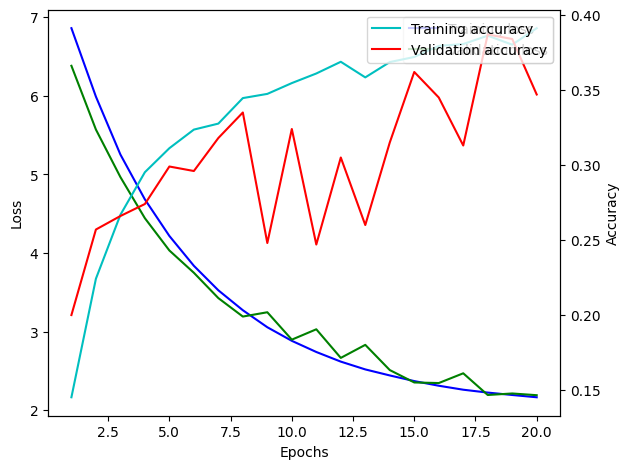

Epoch 1/20
157/157 [==============================] - 6s 31ms/step - loss: 6.8525 - acc: 0.1478 - val_loss: 6.3708 - val_acc: 0.1970
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 5.9599 - acc: 0.2232
Epoch 2: val_acc improved from -inf to 0.19600, saving model to my_model.h5
157/157 [==============================] - 5s 29ms/step - loss: 5.9563 - acc: 0.2244 - val_loss: 5.6106 - val_acc: 0.1960
Epoch 3/20
157/157 [==============================] - 6s 37ms/step - loss: 5.2457 - acc: 0.2672 - val_loss: 4.9434 - val_acc: 0.2660
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.6771 - acc: 0.2885
Epoch 4: val_acc improved from 0.19600 to 0.28100, saving model to my_model.h5
157/157 [==============================] - 5s 29ms/step - loss: 4.6750 - acc: 0.2886 - val_loss: 4.4268 - val_acc: 0.2810
Epoch 5/20
157/157 [==============================] - 5s 32ms/step - loss: 4.2192 - acc: 0.2964 - val_loss: 4.0335 - val_acc: 0.3010
Epoch 6/20
155/157 [

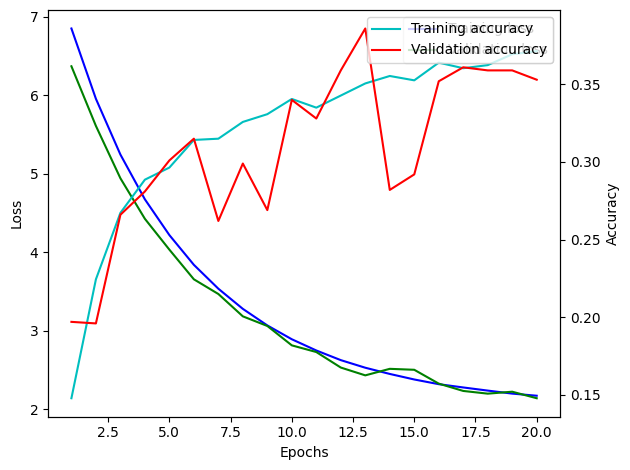

Epoch 1/20
157/157 [==============================] - 6s 36ms/step - loss: 6.8503 - acc: 0.1482 - val_loss: 6.3917 - val_acc: 0.2240
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 5.9881 - acc: 0.2304
Epoch 2: val_acc improved from -inf to 0.27600, saving model to my_model.h5
157/157 [==============================] - 5s 31ms/step - loss: 5.9848 - acc: 0.2310 - val_loss: 5.5776 - val_acc: 0.2760
Epoch 3/20
157/157 [==============================] - 5s 30ms/step - loss: 5.2573 - acc: 0.2652 - val_loss: 4.9424 - val_acc: 0.2730
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.6927 - acc: 0.2821
Epoch 4: val_acc did not improve from 0.27600
157/157 [==============================] - 6s 37ms/step - loss: 4.6913 - acc: 0.2822 - val_loss: 4.4980 - val_acc: 0.2520
Epoch 5/20
157/157 [==============================] - 5s 30ms/step - loss: 4.2327 - acc: 0.3010 - val_loss: 4.0382 - val_acc: 0.2930
Epoch 6/20
156/157 [============================>.] -

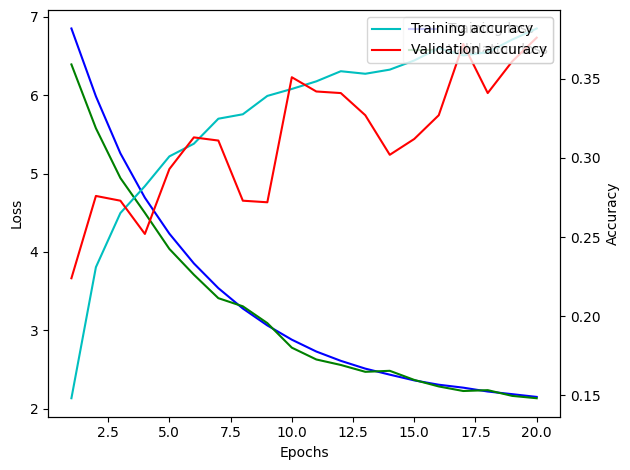

Epoch 1/20
157/157 [==============================] - 6s 37ms/step - loss: 6.8764 - acc: 0.1350 - val_loss: 6.4072 - val_acc: 0.2050
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 6.0008 - acc: 0.2173
Epoch 2: val_acc improved from -inf to 0.23700, saving model to my_model.h5
157/157 [==============================] - 5s 29ms/step - loss: 6.0005 - acc: 0.2176 - val_loss: 5.6090 - val_acc: 0.2370
Epoch 3/20
157/157 [==============================] - 5s 30ms/step - loss: 5.2739 - acc: 0.2586 - val_loss: 4.9526 - val_acc: 0.3050
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 4.6992 - acc: 0.2877
Epoch 4: val_acc improved from 0.23700 to 0.26600, saving model to my_model.h5
157/157 [==============================] - 6s 37ms/step - loss: 4.6992 - acc: 0.2874 - val_loss: 4.4688 - val_acc: 0.2660
Epoch 5/20
157/157 [==============================] - 5s 30ms/step - loss: 4.2364 - acc: 0.2994 - val_loss: 4.0488 - val_acc: 0.2900
Epoch 6/20
156/157 [

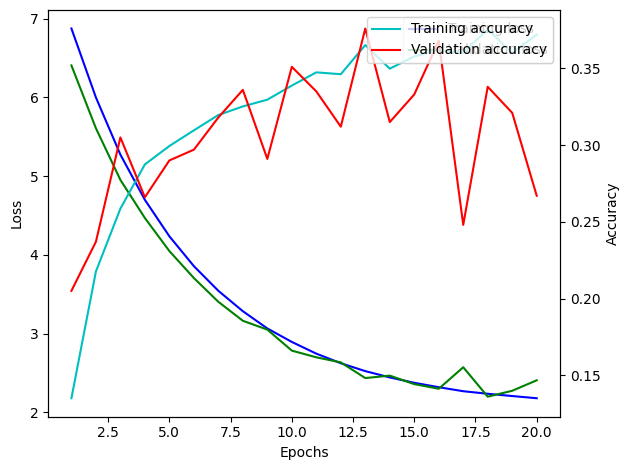

Epoch 1/20
157/157 [==============================] - 6s 37ms/step - loss: 6.7891 - acc: 0.1550 - val_loss: 6.3001 - val_acc: 0.1800
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 5.8973 - acc: 0.2256
Epoch 2: val_acc improved from -inf to 0.19500, saving model to my_model.h5
157/157 [==============================] - 5s 31ms/step - loss: 5.8968 - acc: 0.2258 - val_loss: 5.5351 - val_acc: 0.1950
Epoch 3/20
157/157 [==============================] - 5s 32ms/step - loss: 5.2028 - acc: 0.2634 - val_loss: 4.9386 - val_acc: 0.2310
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.6507 - acc: 0.2909
Epoch 4: val_acc improved from 0.19500 to 0.27200, saving model to my_model.h5
157/157 [==============================] - 5s 35ms/step - loss: 4.6495 - acc: 0.2902 - val_loss: 4.4464 - val_acc: 0.2720
Epoch 5/20
157/157 [==============================] - 5s 30ms/step - loss: 4.2013 - acc: 0.3010 - val_loss: 4.0718 - val_acc: 0.2310
Epoch 6/20
155/157 [

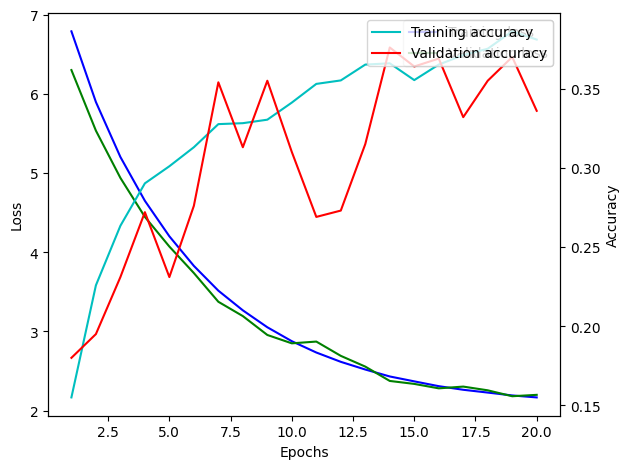

Epoch 1/20
157/157 [==============================] - 7s 38ms/step - loss: 6.8460 - acc: 0.1810 - val_loss: 6.3108 - val_acc: 0.2220
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 5.9257 - acc: 0.2512
Epoch 2: val_acc improved from -inf to 0.27900, saving model to my_model.h5
157/157 [==============================] - 5s 31ms/step - loss: 5.9231 - acc: 0.2504 - val_loss: 5.5226 - val_acc: 0.2790
Epoch 3/20
157/157 [==============================] - 5s 34ms/step - loss: 5.2211 - acc: 0.2836 - val_loss: 4.8999 - val_acc: 0.2960
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.6617 - acc: 0.3006
Epoch 4: val_acc did not improve from 0.27900
157/157 [==============================] - 5s 34ms/step - loss: 4.6597 - acc: 0.3008 - val_loss: 4.4382 - val_acc: 0.2680
Epoch 5/20
157/157 [==============================] - 5s 31ms/step - loss: 4.2048 - acc: 0.3066 - val_loss: 4.0954 - val_acc: 0.2740
Epoch 6/20
155/157 [============================>.] -

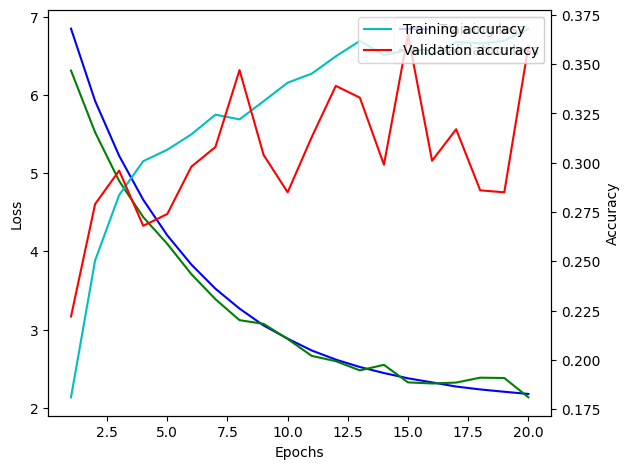

Epoch 1/20
157/157 [==============================] - 6s 35ms/step - loss: 6.8519 - acc: 0.1480 - val_loss: 6.3840 - val_acc: 0.2040
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 5.9857 - acc: 0.2171
Epoch 2: val_acc improved from -inf to 0.27500, saving model to my_model.h5
157/157 [==============================] - 5s 34ms/step - loss: 5.9827 - acc: 0.2168 - val_loss: 5.5725 - val_acc: 0.2750
Epoch 3/20
157/157 [==============================] - 5s 31ms/step - loss: 5.2497 - acc: 0.2712 - val_loss: 4.9540 - val_acc: 0.2670
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.6742 - acc: 0.2883
Epoch 4: val_acc improved from 0.27500 to 0.32400, saving model to my_model.h5
157/157 [==============================] - 5s 35ms/step - loss: 4.6721 - acc: 0.2890 - val_loss: 4.3957 - val_acc: 0.3240
Epoch 5/20
157/157 [==============================] - 5s 33ms/step - loss: 4.2027 - acc: 0.3022 - val_loss: 3.9973 - val_acc: 0.3240
Epoch 6/20
155/157 [

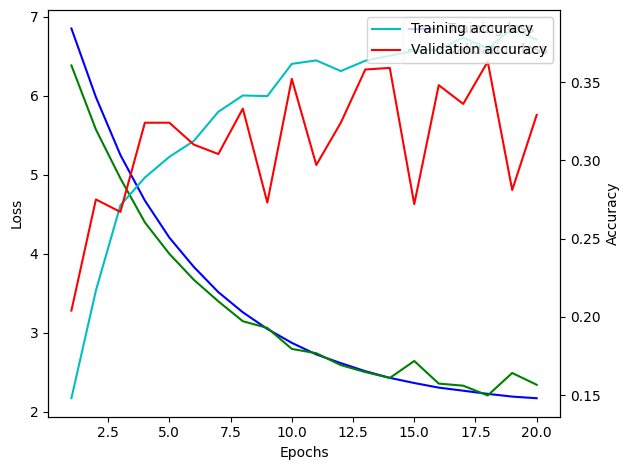

Epoch 1/20
157/157 [==============================] - 6s 37ms/step - loss: 6.8547 - acc: 0.1258 - val_loss: 6.4034 - val_acc: 0.1700
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 5.9968 - acc: 0.2105
Epoch 2: val_acc improved from -inf to 0.25600, saving model to my_model.h5
157/157 [==============================] - 6s 35ms/step - loss: 5.9961 - acc: 0.2108 - val_loss: 5.5820 - val_acc: 0.2560
Epoch 3/20
157/157 [==============================] - 5s 33ms/step - loss: 5.2449 - acc: 0.2576 - val_loss: 4.9461 - val_acc: 0.2550
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 4.6655 - acc: 0.2806
Epoch 4: val_acc improved from 0.25600 to 0.28600, saving model to my_model.h5
157/157 [==============================] - 6s 35ms/step - loss: 4.6648 - acc: 0.2808 - val_loss: 4.4161 - val_acc: 0.2860
Epoch 5/20
157/157 [==============================] - 5s 33ms/step - loss: 4.2016 - acc: 0.3038 - val_loss: 4.1151 - val_acc: 0.2130
Epoch 6/20
155/157 [

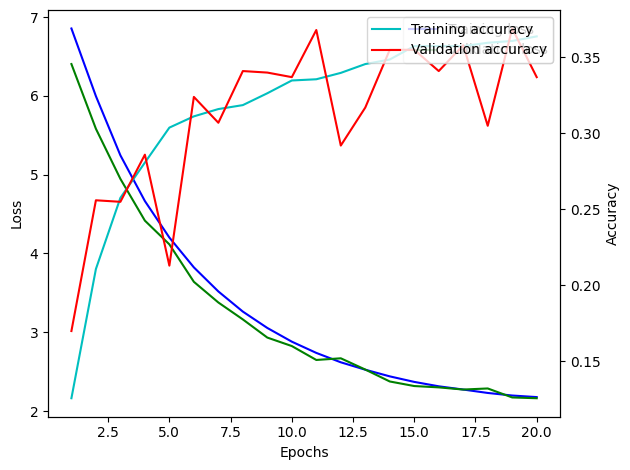

Epoch 1/20
157/157 [==============================] - 7s 37ms/step - loss: 3.9742 - acc: 0.2144 - val_loss: 2.7155 - val_acc: 0.2680
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 2.4522 - acc: 0.2784
Epoch 2: val_acc improved from -inf to 0.33400, saving model to my_model.h5
157/157 [==============================] - 5s 33ms/step - loss: 2.4511 - acc: 0.2780 - val_loss: 2.2698 - val_acc: 0.3340
Epoch 3/20
157/157 [==============================] - 5s 32ms/step - loss: 2.2530 - acc: 0.2970 - val_loss: 2.1656 - val_acc: 0.3230
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 2.1840 - acc: 0.3149
Epoch 4: val_acc improved from 0.33400 to 0.35300, saving model to my_model.h5
157/157 [==============================] - 6s 35ms/step - loss: 2.1849 - acc: 0.3140 - val_loss: 2.0808 - val_acc: 0.3530
Epoch 5/20
157/157 [==============================] - 5s 34ms/step - loss: 2.1357 - acc: 0.3206 - val_loss: 2.0678 - val_acc: 0.3510
Epoch 6/20
155/157 [

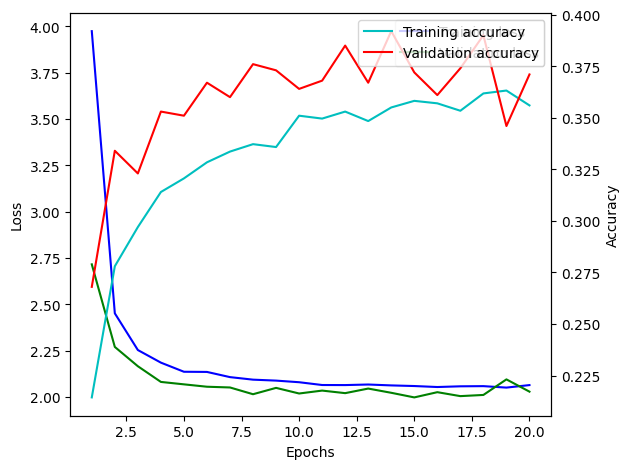

Epoch 1/20
157/157 [==============================] - 7s 35ms/step - loss: 3.9776 - acc: 0.2120 - val_loss: 2.6719 - val_acc: 0.2430
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 2.4576 - acc: 0.2653
Epoch 2: val_acc improved from -inf to 0.29500, saving model to my_model.h5
157/157 [==============================] - 5s 34ms/step - loss: 2.4572 - acc: 0.2660 - val_loss: 2.2928 - val_acc: 0.2950
Epoch 3/20
157/157 [==============================] - 5s 33ms/step - loss: 2.2640 - acc: 0.2894 - val_loss: 2.1699 - val_acc: 0.3320
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 2.2026 - acc: 0.2981
Epoch 4: val_acc improved from 0.29500 to 0.31400, saving model to my_model.h5
157/157 [==============================] - 6s 36ms/step - loss: 2.2028 - acc: 0.2976 - val_loss: 2.1177 - val_acc: 0.3140
Epoch 5/20
157/157 [==============================] - 6s 35ms/step - loss: 2.1511 - acc: 0.3226 - val_loss: 2.2119 - val_acc: 0.2980
Epoch 6/20
156/157 [

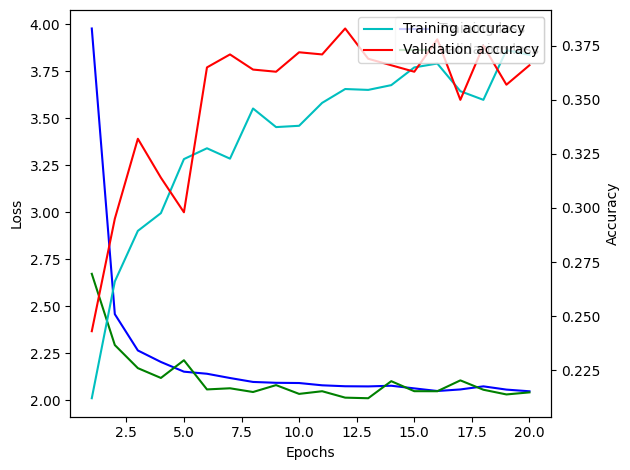

Epoch 1/20
157/157 [==============================] - 7s 37ms/step - loss: 3.9314 - acc: 0.2102 - val_loss: 2.6227 - val_acc: 0.2570
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 2.4286 - acc: 0.2732
Epoch 2: val_acc improved from -inf to 0.27500, saving model to my_model.h5
157/157 [==============================] - 5s 34ms/step - loss: 2.4286 - acc: 0.2732 - val_loss: 2.3307 - val_acc: 0.2750
Epoch 3/20
157/157 [==============================] - 5s 33ms/step - loss: 2.2519 - acc: 0.2960 - val_loss: 2.1932 - val_acc: 0.3210
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 2.1735 - acc: 0.3149
Epoch 4: val_acc improved from 0.27500 to 0.30800, saving model to my_model.h5
157/157 [==============================] - 6s 35ms/step - loss: 2.1744 - acc: 0.3150 - val_loss: 2.1188 - val_acc: 0.3080
Epoch 5/20
157/157 [==============================] - 5s 34ms/step - loss: 2.1449 - acc: 0.3126 - val_loss: 2.0795 - val_acc: 0.3460
Epoch 6/20
155/157 [

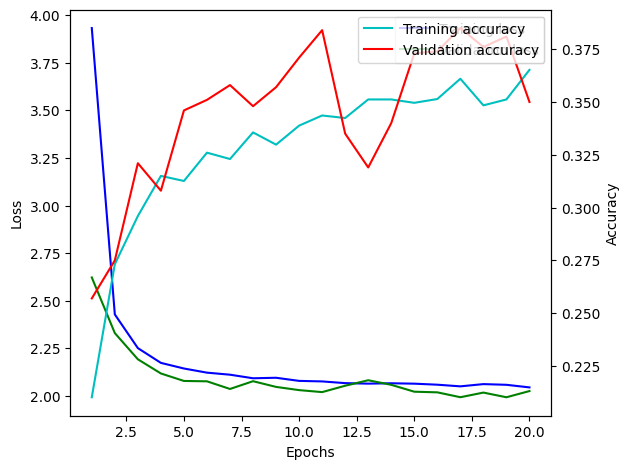

Epoch 1/20
157/157 [==============================] - 7s 37ms/step - loss: 3.8461 - acc: 0.2134 - val_loss: 2.6337 - val_acc: 0.2670
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 2.4455 - acc: 0.2601
Epoch 2: val_acc improved from -inf to 0.29600, saving model to my_model.h5
157/157 [==============================] - 6s 36ms/step - loss: 2.4449 - acc: 0.2606 - val_loss: 2.2952 - val_acc: 0.2960
Epoch 3/20
157/157 [==============================] - 6s 35ms/step - loss: 2.2594 - acc: 0.2748 - val_loss: 2.1792 - val_acc: 0.3190
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 2.1705 - acc: 0.3073
Epoch 4: val_acc improved from 0.29600 to 0.33900, saving model to my_model.h5
157/157 [==============================] - 6s 36ms/step - loss: 2.1698 - acc: 0.3082 - val_loss: 2.1162 - val_acc: 0.3390
Epoch 5/20
157/157 [==============================] - 5s 32ms/step - loss: 2.1440 - acc: 0.3008 - val_loss: 2.1141 - val_acc: 0.3640
Epoch 6/20
155/157 [

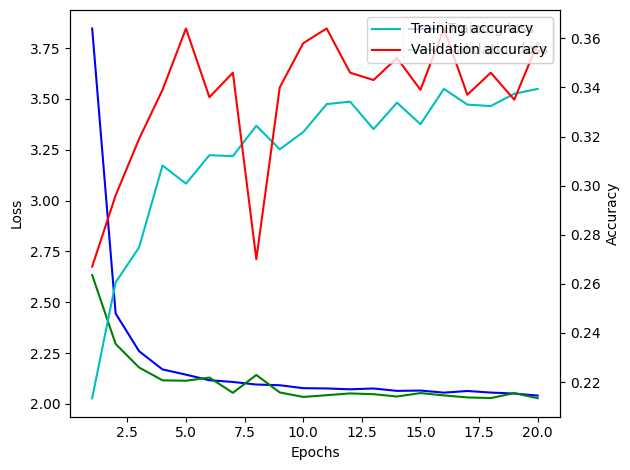

Epoch 1/20
157/157 [==============================] - 6s 37ms/step - loss: 8.1744 - acc: 0.1478 - val_loss: 7.4126 - val_acc: 0.1880
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 6.7818 - acc: 0.2268
Epoch 2: val_acc improved from -inf to 0.24600, saving model to my_model.h5
157/157 [==============================] - 5s 35ms/step - loss: 6.7777 - acc: 0.2268 - val_loss: 6.1791 - val_acc: 0.2460
Epoch 3/20
157/157 [==============================] - 5s 35ms/step - loss: 5.7077 - acc: 0.2618 - val_loss: 5.3118 - val_acc: 0.2610
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.9039 - acc: 0.2831
Epoch 4: val_acc improved from 0.24600 to 0.26700, saving model to my_model.h5
157/157 [==============================] - 6s 36ms/step - loss: 4.8995 - acc: 0.2840 - val_loss: 4.5778 - val_acc: 0.2670
Epoch 5/20
157/157 [==============================] - 5s 35ms/step - loss: 4.2823 - acc: 0.2960 - val_loss: 4.0363 - val_acc: 0.2840
Epoch 6/20
155/157 [

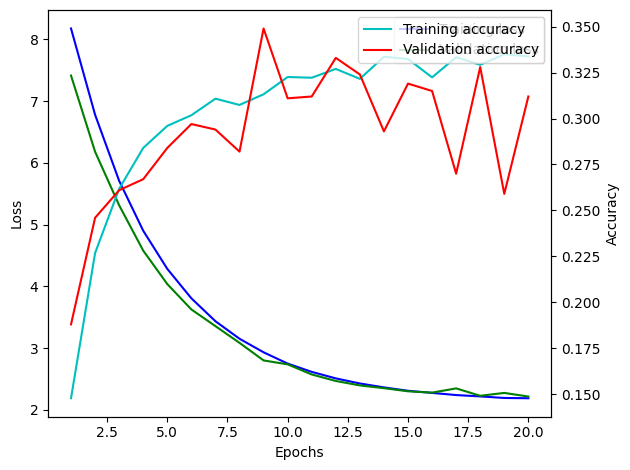

Epoch 1/20
157/157 [==============================] - 7s 39ms/step - loss: 8.2429 - acc: 0.1764 - val_loss: 7.4703 - val_acc: 0.1870
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 6.8233 - acc: 0.2373
Epoch 2: val_acc improved from -inf to 0.23500, saving model to my_model.h5
157/157 [==============================] - 5s 33ms/step - loss: 6.8168 - acc: 0.2384 - val_loss: 6.2481 - val_acc: 0.2350
Epoch 3/20
157/157 [==============================] - 5s 34ms/step - loss: 5.7391 - acc: 0.2676 - val_loss: 5.2914 - val_acc: 0.2960
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.9301 - acc: 0.2891
Epoch 4: val_acc improved from 0.23500 to 0.28200, saving model to my_model.h5
157/157 [==============================] - 6s 36ms/step - loss: 4.9260 - acc: 0.2896 - val_loss: 4.6430 - val_acc: 0.2820
Epoch 5/20
157/157 [==============================] - 5s 35ms/step - loss: 4.2996 - acc: 0.2986 - val_loss: 4.0759 - val_acc: 0.2720
Epoch 6/20
156/157 [

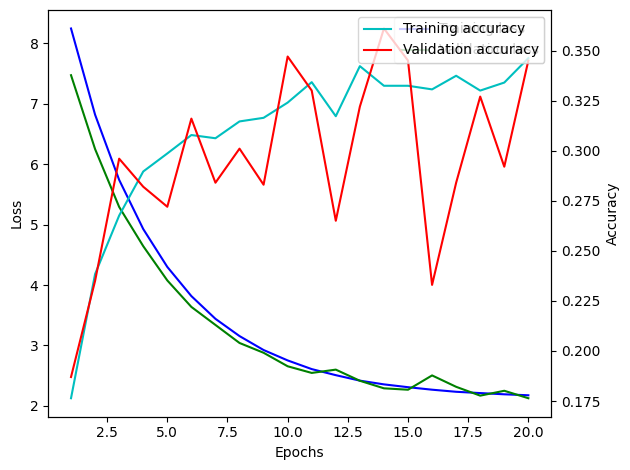

Epoch 1/20
157/157 [==============================] - 7s 39ms/step - loss: 8.2168 - acc: 0.1370 - val_loss: 7.4580 - val_acc: 0.1960
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 6.8360 - acc: 0.2050
Epoch 2: val_acc improved from -inf to 0.21500, saving model to my_model.h5
157/157 [==============================] - 5s 34ms/step - loss: 6.8317 - acc: 0.2054 - val_loss: 6.2232 - val_acc: 0.2150
Epoch 3/20
157/157 [==============================] - 6s 35ms/step - loss: 5.7472 - acc: 0.2456 - val_loss: 5.2942 - val_acc: 0.2520
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.9245 - acc: 0.2653
Epoch 4: val_acc improved from 0.21500 to 0.24900, saving model to my_model.h5
157/157 [==============================] - 6s 35ms/step - loss: 4.9215 - acc: 0.2656 - val_loss: 4.6031 - val_acc: 0.2490
Epoch 5/20
157/157 [==============================] - 5s 35ms/step - loss: 4.2965 - acc: 0.2936 - val_loss: 4.0075 - val_acc: 0.3190
Epoch 6/20
155/157 [

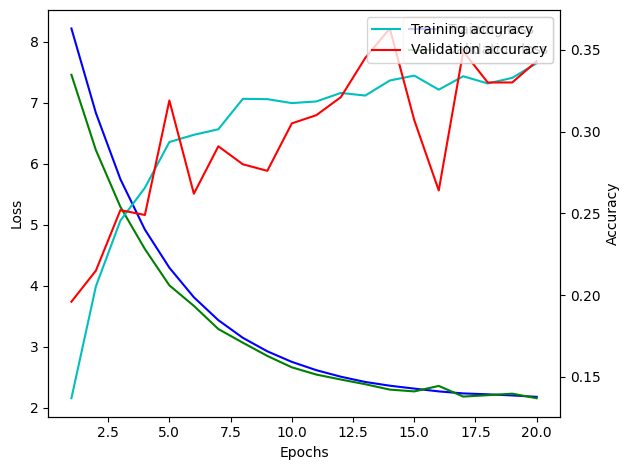

Epoch 1/20
157/157 [==============================] - 7s 39ms/step - loss: 8.1872 - acc: 0.1870 - val_loss: 7.3987 - val_acc: 0.2120
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 6.7613 - acc: 0.2613
Epoch 2: val_acc improved from -inf to 0.21500, saving model to my_model.h5
157/157 [==============================] - 5s 33ms/step - loss: 6.7573 - acc: 0.2606 - val_loss: 6.2472 - val_acc: 0.2150
Epoch 3/20
157/157 [==============================] - 5s 35ms/step - loss: 5.7029 - acc: 0.2876 - val_loss: 5.2558 - val_acc: 0.2930
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 4.9043 - acc: 0.3016
Epoch 4: val_acc improved from 0.21500 to 0.29800, saving model to my_model.h5
157/157 [==============================] - 5s 35ms/step - loss: 4.9021 - acc: 0.3008 - val_loss: 4.5672 - val_acc: 0.2980
Epoch 5/20
157/157 [==============================] - 5s 35ms/step - loss: 4.2865 - acc: 0.3098 - val_loss: 4.0251 - val_acc: 0.3010
Epoch 6/20
155/157 [

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import time
from keras.optimizers import Adam, SGD

for batchh in [32,16,8,4]:
  for dpt in [i/100 for i in range(6)]:
    for n_neut in [64,32,16]:
      for l22 in [j/100 for j in range(6)]:
        for optt in ['sgd','sgd2','adam']:
          for lrr in [0.1,0.01,0.001,0.0001]:
            print(batchh, dpt, n_neut, l22, optt, lrr)
            model = Sequential()
            model.add(Conv2D(filters=8,
                             kernel_size=(3, 3),
                             activation='relu',
                             padding='same',
                             input_shape=(32, 32, 3),
                             kernel_regularizer=l2(l22)))
            model.add(MaxPool2D(pool_size=(2, 2)))

            # # 新增的第一个卷积层
            model.add(Conv2D(filters=16,  # 增加滤波器的数量
                             kernel_size=(3, 3),
                             activation='relu',
                             padding='same',
                             kernel_regularizer=l2(l22)))
            model.add(MaxPool2D(pool_size=(2, 2)))

            # 新增的第二个卷积层
            model.add(Conv2D(filters=32,  # 再次增加滤波器的数量
                             kernel_size=(3, 3),
                             activation='relu',
                             padding='same',
                             kernel_regularizer=l2(l22)))
            model.add(MaxPool2D(pool_size=(2, 2)))

            model.add(Flatten())
            model.add(Dense(n_neut, activation='relu', kernel_regularizer = l2(l22)))
            model.add(Dropout(dpt))
            model.add(Dense(10, activation='softmax', kernel_regularizer = l2(l22)))

            weights_init = model.get_weights()
            if optt == 'sgd':
              opt = SGD(lr=lrr,momentum=0.0)
            if optt == 'sgd2':
              opt = SGD(lr=lrr,momentum=0.01)
            if optt == 'adam':
              opt = Adam(lr=lrr)
            model.compile(optimizer=opt,
                         loss='categorical_crossentropy',
                         metrics=['acc'])
            class TimeHistory(Callback):
                def on_train_begin(self, logs={}):
                    self.times = []
                def on_epoch_begin(self, batch, logs={}):
                    self.epoch_time_start = time.time()
                def on_epoch_end(self, batch, logs={}):
                    self.times.append(time.time() - self.epoch_time_start)
            time_callback = TimeHistory()
            filepath = "my_model.h5"
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=2)
            callbacks = [time_callback, checkpoint]
            history = model.fit(x_train, y_train, batch_size=batchh, epochs=20, verbose=1, validation_data=(x_val, y_val), callbacks=callbacks)
            times = time_callback.times
            print("Mean: {}".format(np.mean(times)))
            print("Std: {}".format(np.std(times)))
            history_dict = history.history
            loss_values = history_dict['loss']
            val_loss_values = history_dict['val_loss']
            acc_values = history_dict['acc']
            val_acc_values = history_dict['val_acc']
            epochs = range(1, len(history_dict['acc']) + 1)
            fig, ax1 = plt.subplots()
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')
            ax1.plot(epochs, loss_values, color='b', label='Training loss')
            ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
            ax1.tick_params(axis='y')
            plt.legend()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
            ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
            ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
            ax2.tick_params(axis='y')
            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.legend(loc=1)
            plt.show()

### Sur-apprentissage - Q2

Epoch 1/20
157/157 [==============================] - 4s 21ms/step - loss: 1.9664 - acc: 0.3116 - val_loss: 1.8351 - val_acc: 0.3530
Epoch 2/20
153/157 [============================>.] - ETA: 0s - loss: 1.5872 - acc: 0.4496
Epoch 2: val_acc improved from -inf to 0.39800, saving model to my_model.h5
157/157 [==============================] - 3s 16ms/step - loss: 1.5897 - acc: 0.4468 - val_loss: 1.7006 - val_acc: 0.3980
Epoch 3/20
157/157 [==============================] - 3s 22ms/step - loss: 1.3738 - acc: 0.5218 - val_loss: 1.5727 - val_acc: 0.4390
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 1.1862 - acc: 0.5923
Epoch 4: val_acc improved from 0.39800 to 0.46200, saving model to my_model.h5
157/157 [==============================] - 3s 21ms/step - loss: 1.1887 - acc: 0.5910 - val_loss: 1.5661 - val_acc: 0.4620
Epoch 5/20
157/157 [==============================] - 5s 34ms/step - loss: 1.0340 - acc: 0.6486 - val_loss: 1.6089 - val_acc: 0.4750
Epoch 6/20
157/157 [

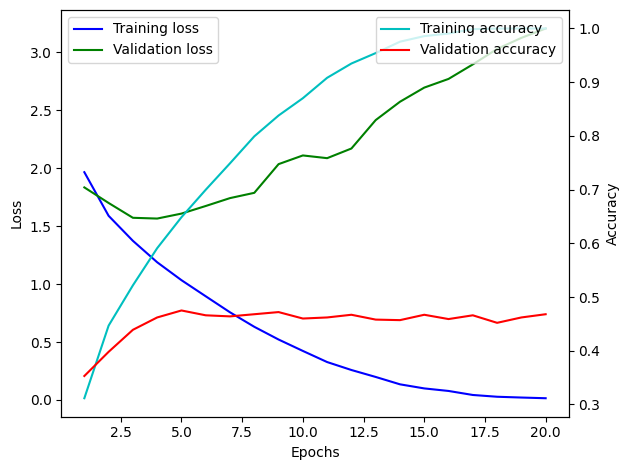

In [ ]:
# original
model = Sequential()
model.add(Conv2D(filters=8,
                kernel_size = (3, 3),
                activation = 'relu',
                padding = 'same',
                input_shape = (32, 32, 3),
                kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))
model.add(Dense(10, activation='softmax', kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))
weights_init = model.get_weights()
# opt = SGD(lr=0.01,momentum=0.0)
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['acc'])
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()
filepath = "my_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=2)
callbacks = [time_callback, checkpoint]
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val), callbacks=callbacks)
times = time_callback.times
print("Mean: {}".format(np.mean(times)))
print("Std: {}".format(np.std(times)))
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epochs, loss_values, color='b', label='Training loss')
ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
ax1.tick_params(axis='y')
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
ax2.tick_params(axis='y')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(loc=1)
plt.show()

Epoch 1/20
157/157 [==============================] - 6s 33ms/step - loss: 4.1815 - acc: 0.2626 - val_loss: 2.6307 - val_acc: 0.2950
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 2.4017 - acc: 0.3238
Epoch 2: val_acc improved from -inf to 0.35800, saving model to my_model.h5
157/157 [==============================] - 4s 25ms/step - loss: 2.4017 - acc: 0.3238 - val_loss: 2.2797 - val_acc: 0.3580
Epoch 3/20
157/157 [==============================] - 5s 30ms/step - loss: 2.2264 - acc: 0.3540 - val_loss: 2.2134 - val_acc: 0.3530
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 2.1665 - acc: 0.3564
Epoch 4: val_acc improved from 0.35800 to 0.37500, saving model to my_model.h5
157/157 [==============================] - 6s 37ms/step - loss: 2.1665 - acc: 0.3564 - val_loss: 2.1504 - val_acc: 0.3750
Epoch 5/20
157/157 [==============================] - 4s 24ms/step - loss: 2.1287 - acc: 0.3682 - val_loss: 2.1245 - val_acc: 0.4030
Epoch 6/20
154/157 [

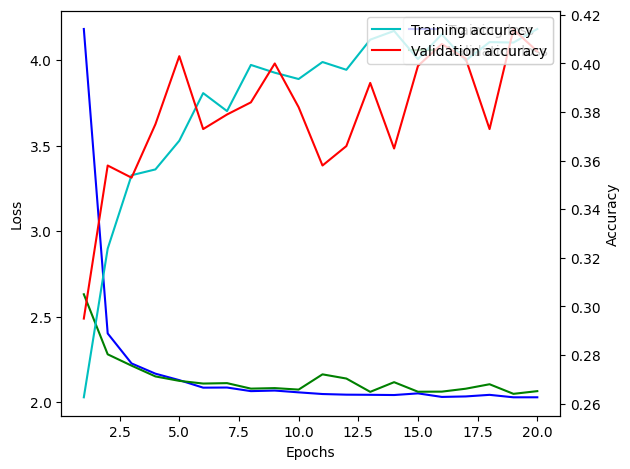

In [ ]:
# l2
model = Sequential()
model.add(Conv2D(filters=8,
                kernel_size = (3, 3),
                activation = 'relu',
                padding = 'same',
                input_shape = (32, 32, 3),
                kernel_regularizer = l2(0.05)))
model.add(Dropout(0.0))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = l2(0.05)))
model.add(Dropout(0.0))
model.add(Dense(10, activation='softmax', kernel_regularizer = l2(0.05)))
model.add(Dropout(0.0))
weights_init = model.get_weights()
# opt = SGD(lr=0.01,momentum=0.0)
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['acc'])
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()
filepath = "my_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=2)
callbacks = [time_callback, checkpoint]
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val), callbacks=callbacks)
times = time_callback.times
print("Mean: {}".format(np.mean(times)))
print("Std: {}".format(np.std(times)))
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epochs, loss_values, color='b', label='Training loss')
ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
ax1.tick_params(axis='y')
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
ax2.tick_params(axis='y')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(loc=1)
plt.show()

Epoch 1/20
157/157 [==============================] - 5s 26ms/step - loss: 2.1291 - acc: 0.2350 - val_loss: 1.9570 - val_acc: 0.3270
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 1.8657 - acc: 0.3329
Epoch 2: val_acc improved from -inf to 0.37900, saving model to my_model.h5
157/157 [==============================] - 4s 27ms/step - loss: 1.8647 - acc: 0.3336 - val_loss: 1.7987 - val_acc: 0.3790
Epoch 3/20
157/157 [==============================] - 3s 21ms/step - loss: 1.6761 - acc: 0.4052 - val_loss: 1.6800 - val_acc: 0.4190
Epoch 4/20
155/157 [============================>.] - ETA: 0s - loss: 1.5551 - acc: 0.4490
Epoch 4: val_acc improved from 0.37900 to 0.43900, saving model to my_model.h5
157/157 [==============================] - 3s 20ms/step - loss: 1.5539 - acc: 0.4494 - val_loss: 1.6031 - val_acc: 0.4390
Epoch 5/20
157/157 [==============================] - 4s 23ms/step - loss: 1.4362 - acc: 0.4882 - val_loss: 1.5701 - val_acc: 0.4490
Epoch 6/20
156/157 [

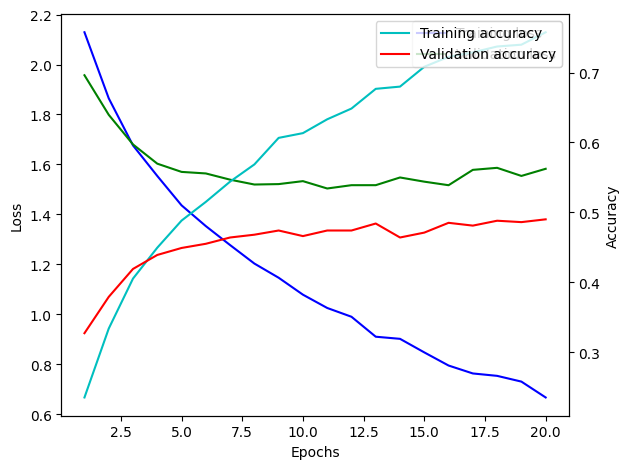

In [ ]:
# dropout
model = Sequential()
model.add(Conv2D(filters=8,
                kernel_size = (3, 3),
                activation = 'relu',
                padding = 'same',
                input_shape = (32, 32, 3),
                kernel_regularizer = l2(0.00)))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = l2(0.00)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax', kernel_regularizer = l2(0.00)))
# model.add(Dropout(0.1))
weights_init = model.get_weights()
# opt = SGD(lr=0.01,momentum=0.0)
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['acc'])
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()
filepath = "my_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=2)
callbacks = [time_callback, checkpoint]
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val), callbacks=callbacks)
times = time_callback.times
print("Mean: {}".format(np.mean(times)))
print("Std: {}".format(np.std(times)))
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epochs, loss_values, color='b', label='Training loss')
ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
ax1.tick_params(axis='y')
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
ax2.tick_params(axis='y')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(loc=1)
plt.show()

Epoch 1/20
157/157 [==============================] - 6s 29ms/step - loss: 1.9084 - acc: 0.3360 - val_loss: 1.7339 - val_acc: 0.3890
Epoch 2/20
154/157 [============================>.] - ETA: 0s - loss: 1.4831 - acc: 0.5181
Epoch 2: val_acc improved from -inf to 0.41000, saving model to my_model.h5
157/157 [==============================] - 3s 21ms/step - loss: 1.4832 - acc: 0.5170 - val_loss: 1.6969 - val_acc: 0.4100
Epoch 3/20
157/157 [==============================] - 3s 21ms/step - loss: 1.2462 - acc: 0.6262 - val_loss: 1.6706 - val_acc: 0.4250
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 1.0345 - acc: 0.7246
Epoch 4: val_acc improved from 0.41000 to 0.41500, saving model to my_model.h5
157/157 [==============================] - 4s 26ms/step - loss: 1.0347 - acc: 0.7246 - val_loss: 1.6939 - val_acc: 0.4150
Epoch 5/20
157/157 [==============================] - 3s 22ms/step - loss: 0.8527 - acc: 0.7992 - val_loss: 1.6686 - val_acc: 0.4430
Epoch 6/20
155/157 [

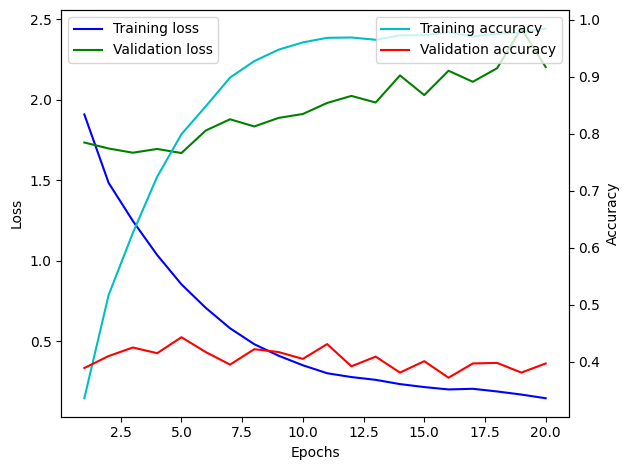

In [ ]:
# BN layer

from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(filters=8,
                 kernel_size=(3, 3),
                 padding='same',
                 input_shape=(32, 32, 3),
                 kernel_regularizer=l2(0.00)))
model.add(BatchNormalization())  # 添加 BatchNormalization 层
model.add(Activation('relu'))    # 激活函数现在是一个独立的层
model.add(Dropout(0.0))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l2(0.00)))
model.add(BatchNormalization())  # 添加 BatchNormalization 层
model.add(Activation('relu'))    # 激活函数现在是一个独立的层
model.add(Dropout(0.0))

model.add(Dense(10, kernel_regularizer=l2(0.00)))
model.add(BatchNormalization())  # 添加 BatchNormalization 层
model.add(Activation('softmax')) # 激活函数现在是一个独立的层
model.add(Dropout(0.0))

weights_init = model.get_weights()
# opt = SGD(lr=0.01,momentum=0.0)
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['acc'])
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()
filepath = "my_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=2)
callbacks = [time_callback, checkpoint]
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val), callbacks=callbacks)
times = time_callback.times
print("Mean: {}".format(np.mean(times)))
print("Std: {}".format(np.std(times)))
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epochs, loss_values, color='b', label='Training loss')
ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
ax1.tick_params(axis='y')
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
ax2.tick_params(axis='y')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(loc=1)
plt.show()